In [1]:
#!/usr/bin/env python
# coding: utf-8

#import pandas for dataframes, import seaborn for graphs, import csv, import os for file handling
get_ipython().run_line_magic('matplotlib', 'inline')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) #suppress futurewarnings from matplotlib
import pandas as pd
import seaborn as sns
import os
import webbrowser
from scipy import stats as st
import csv
from csv import writer
from sklearn.linear_model import LinearRegression
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

sns.set_theme(style="darkgrid")
sns.set(font_scale = 1.5)

global df
csv_name = 'pipeline_outputs_SAY_10-15-2021.csv'#INPUT csv name here
df = pd.read_csv(csv_name) #import csv
df_data = pd.read_csv("data.csv") #second data sheet

df_data.drop(['BMI','Sex','Age'], axis=1,inplace =True)
df = df.merge(df_data, on="subject_id", how = 'left')

list_outliers = {} #global list of outliers for later use

study_name = "SAY" #INPUT study name
date = "10/15/2021" #INPUT date updated (mm/dd/yyyy)


NameError: name 'make_regression' is not defined

In [23]:
#Heatmap

# corr = df.corr()
# corr_thresh = corr[(corr>.975) & (corr<1)]
# corr_thresh.fillna(value = 0,inplace=True)
# for col in corr_thresh:
#     counter = len(corr_thresh[col])
#     for item in corr_thresh[col]:
#         if item ==0:
#             counter-=1
#     if counter == 0:
#         corr_thresh.drop(col,axis=1,inplace=True)
#         corr_thresh.drop(col,axis=0,inplace=True)
# corr2 = corr_thresh.corr()

# fig, ax = plt.subplots(figsize=(75,75))
# ax = sns.heatmap(corr2)
# fig1 = ax.get_figure() 
# fig1.savefig('heatmap_95.png') #save each plot in local folder
# plt.close(fig1)
# fig, ax = plt.subplots(figsize=(100,100))
# ax = sns.heatmap(corr)
# fig2 = ax.get_figure() 
# fig2.savefig('heatmap_total.png') #save each plot in local folder
# plt.close(fig2)

In [24]:
#drop unneeded columns - FOR OTHER STUDIES, UNCOMMENT
# col_name=""
#--------------------------------------------------------------------------------------------------------------------
# with open('') as f: #INPUT variables_to_remove here (ensure file in local folder, or insert path)
#     col_name = f.read()
# col_toRemove = col_name.split(", ")
# for col in col_toRemove:
#     if col in df.columns:
#         del df[col]

#drop unneeded columns ---> FOR USE WITH PAUL'S OUTPUTS ONLY, COMMENT OUT FOR OTHER STUDIES
for col in df.columns:
    if (('GlobalEfficiency' in col) or ('MaximizedModularity' in col) 
        or ('MeanClusteringCoeff' in col) or ('MeanTotalStrength'in col)
        or ('NetworkCharacteristic' in col) or ('TotalStrength' in col)
        or ('dummyrest' in col) or ('session_id' in col) or ('subject_id' in col)
        or ('dummy_rest' in col) or ('file_name' in col) or ('1back' in col)
        or ('acq_id' in col) or ('anatomical_zstat1' in col)):
        del df[col]

#filter id columns to include only integers
for id in df['id0'].dropna():
    if(len(id)>3):
        idnum=id[-3:]
        df['id0']=df['id0'].replace(id,idnum) 

In [25]:
#create csv file for data
def write(var, col, slope, intercept, r_value, p_value, std_err, slope2=-1, intercept2=-1, r_value2=-1,
          p_value2=-1, std_err2=-1, flag = False):
    
    fname = str(var) + "_data.csv" #csv name    
    if(flag):
        #clear csv file to update values if first time called
        f = open(fname, "w+")
        f.close()
        
    title = [] #placeholder for title row
    if(not isinstance(slope2,np.ndarray) and slope2 == -1): #if second set of data not given
        equation = "y="+str(slope)+"*x+"+str(intercept)
        values = [col,slope,intercept,r_value**2,p_value,std_err,equation]
        title = ["Variable","Slope","Intercept","R^2","P_value","Std_err", "Equation"]
        
    else: #if second set of data is given
        equation = "y="+str(slope)+"*x+"+str(intercept)
        equation2 = "y="+str(slope2)+"*x+"+str(intercept2)
        
        if(var == 'MLR'): #MLR title and values are different than the rest
            values = ["",col,slope,intercept,r_value**2,equation,
                      "",col,slope2,intercept2,r_value2**2,equation2]
            title = ["Male","Variable","Slope (Age, BMI)","Intercept","R^2", "Equation",
                                    "Female","Variable","Slope (Age, BMI)","Intercept","R^2", "Equation"]
        else:
            values = ["",col,slope,intercept,r_value**2,p_value,std_err,equation,
                  "",col,slope2,intercept2,r_value2**2,p_value2,std_err2,equation2]
            title = ["Male","Variable","Slope","Intercept","R^2","p_value","Std_err", "Equation",
                     "Female","Variable","Slope","Intercept","R^2","p_value","Std_err", "Equation"]
        
    with open(fname, 'a', newline='') as f_object: #open in append mode
        writer_object = writer(f_object)
        if(flag): #If first row, add titles
            writer_object.writerow(title)
        writer_object.writerow(values)
        
    f_object.close()

In [26]:
#SAY

#create Age and Sex/BMI and BMIbySex graphs
plt.rcParams.update({'font.size': 30})
def createGraph(col,AgeSex):
        try:
            std_line = df[col].std()
            #create std lines, palette for colors, legend
            std1 = pd.DataFrame(np.full((len(df['id0']),1),std_line+df[col].mean()),columns = ['value'])
            std1 = pd.concat([df['id0'],std1],axis = 1)
            std2 = pd.DataFrame(np.full((len(df['id0']),1),-1*std_line+df[col].mean()),columns = ['value'])
            std2 = pd.concat([df['id0'],std2],axis = 1)
            std3 = pd.DataFrame(np.full((len(df['id0']),1),2*std_line+df[col].mean()),columns = ['value'])
            std3 = pd.concat([df['id0'],std3],axis = 1)
            std4 = pd.DataFrame(np.full((len(df['id0']),1),-2*std_line+df[col].mean()),columns = ['value'])
            std4 = pd.concat([df['id0'],std4],axis = 1)
            d_std = pd.concat([std1,std2,std3,std4],axis= 0,keys=['std1', 'std2','std3','std4']).reset_index()
            d_std = d_std.rename(columns={'level_0': 'line', 'level_1': 'i'})
            pal = ['magenta','magenta','cyan','cyan']
            
            
            ax = sns.lineplot(data = d_std,x = 'id0',y = 'value',hue = 'line', palette = pal, legend = False)            
            ax = sns.scatterplot(x='id0',y=col, data=df)
            ax.set_xlabel('id0',fontsize=14)
            ax.set_ylabel(col, fontsize=14)
            ax.set_xticklabels(df['id0'],rotation=270)
            fig = ax.get_figure() 
            fig.legend(labels=["+\u03C3","-\u03C3","+2\u03C3","-2\u03C3"])
            fig.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
            fig.set_size_inches(8,6)
            if(AgeSex):
                fig.savefig(col+'.png') #save each plot in local folder
            plt.close(fig)

            if(AgeSex):
                #variable over age, linear regression
                ax = sns.jointplot(x='Age',y=col, data=df,kind="reg", truncate=False,
                          color="m", height=7)
               # ax.set_xticklabels(df['Age'],rotation=270)
                fig1 = ax.fig
                fig1.savefig(col+'_Age.png') #save each plot in local folder
                plt.close(fig1)

                #variable over sex, linear regression
                pal = dict(Male="#6495ED", Female="#F08080")
                ax = sns.lmplot(x='Age',y=col, col="Sex", hue="Sex", data=df,
                                palette=pal, y_jitter=.02, truncate=False)
                #ax.set_xticklabels(df['Sex'],rotation=270)
                fig2 = ax.fig
                fig2.set_size_inches(12,6)
                fig2.savefig(col+'_Sex.png') #save each plot in local folder
                plt.close(fig2)
                
            else:
                ax = sns.jointplot(x='BMI',y=col, data=df,kind="reg", truncate=False,
                          color="g", height=7)
                # ax.set_xticklabels(df['Age'],rotation=270)
                fig3 = ax.fig
                fig3.set_size_inches(8,6)
                fig3.savefig(col+'_BMI.png') #save each plot in local folder
                plt.close(fig3)

                #variable over BMI by sex, linear regression
                pal = dict(Male="#6495ED", Female="#F08080")
                ax = sns.lmplot(x='BMI',y=col, col="Sex", hue="Sex", data=df,
                                palette=pal, y_jitter=.02, truncate=False)
                #ax.set_xticklabels(df['Sex'],rotation=270)
                fig2 = ax.fig
                fig2.set_size_inches(12,6)
                fig2.savefig(col+'_BxS.png') #save each plot in local folder
                plt.close(fig2)
                


        except TypeError:
            print('Graph not generated for: '+col) 
        except ValueError:
            print("value: "+col)

In [27]:
#SAY

#create Behvaioral Data graphs

def createBehavioralGraph(col,cols):
    for var in cols:
        try:
            #variable over age, linear regression
            ax = sns.jointplot(x=str(var),y=col, data=df,kind="reg", truncate=False,
                      color="m", height=7)
            fig1 = ax.fig
            fig1.set_size_inches(8,6)
            fig1.savefig(col+'_'+var+'.png') #save each plot in local folder
            plt.close(fig1)

            #variable over sex, linear regression
            pal = dict(Male="#6495ED", Female="#F08080")
            ax = sns.lmplot(x=str(var),y=col, col="Sex", hue="Sex", data=df,
                            palette=pal, y_jitter=.02, truncate=False)
            fig2 = ax.fig
            fig2.set_size_inches(12,6)
            fig2.savefig(col+'_'+var+'_Sex.png') #save each plot in local folder
            plt.close(fig2)

        except TypeError:
            print('Graph not generated for: '+col) 
        except ValueError:
            print("value: "+col)

In [39]:
#3D Graph Generation
def create3DGraph(col, r_value1, r_value2, mlr1, mlr2):
    try:
        #Male
        min1 = df_temp_Male['Age'].min()
        min2 = df_temp_Male['BMI'].min()
        max1 = df_temp_Male['Age'].max()
        max2 = df_temp_Male['BMI'].max()
        
        fig = plt.figure()
        fig.set_size_inches(12, 6)
        ax = fig.add_subplot(121,projection='3d')
        ax.scatter(df_temp_Male['Age'],df_temp_Male['BMI'],df_temp_Male[col],color = 'blue')
        ax.set_title(col + ":\n Male (R^2 = "+str(round(r_value1,5))+")")
        ax.set_xlabel("Age")
        ax.set_ylabel("BMI")
        ax.set_zlabel(col)
        ax.view_init(30,60)
        
        #graph MLR (3D Regression)
        line1 = np.linspace(min1, max1, 30) 
        line2 = np.linspace(min2, max2, 30) 
        xx_pred, yy_pred = np.meshgrid(line1, line2)
        model = np.array([xx_pred.flatten(), yy_pred.flatten()]).T
        predicted = mlr1.predict(model)
        ax.plot_trisurf(xx_pred.flatten(), yy_pred.flatten(), predicted, color=(0,0,0,.3), edgecolor=(0,0,0,.2))
        
        #Female
        min1 = df_temp_Female['Age'].min()
        min2 = df_temp_Female['BMI'].min()
        max1 = df_temp_Female['Age'].max()
        max2 = df_temp_Female['BMI'].max()
        
        ax = fig.add_subplot(122,projection='3d')
        ax.scatter(df_temp_Female['Age'],df_temp_Female['BMI'],df_temp_Female[col],color = 'red')
        ax.set_title(col + ":\n Female (R^2 = "+str(round(r_value2,5))+")")
        ax.set_xlabel("Age")
        ax.set_ylabel("BMI")
        ax.set_zlabel(col)
        ax.view_init(30,60)

        #graph MLR (3D Regression)
        line1 = np.linspace(min1, max1, 30)   # range of porosity values
        line2 = np.linspace(min2, max2, 30)  # range of brittleness values
        xx_pred, yy_pred = np.meshgrid(line1, line2)
        model = np.array([xx_pred.flatten(), yy_pred.flatten()]).T
        predicted2 = mlr2.predict(model)
        ax.plot_trisurf(xx_pred.flatten(), yy_pred.flatten(), predicted2, color=(0,0,0,.3), edgecolor=(0,0,0,.2))
        
        plt.savefig(col+'_3D.png') #save each plot in local folder
        plt.close(fig)

    except ValueError:
        print(col)
    except TypeError:
        print(col+" TypeError")

C:\Users\bnish\AppData\Local\Temp/ipykernel_3864/1183147598.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df['id0'],rotation=270)
No handles with labels found to put in legend.
C:\Users\bnish\AppData\Local\Temp/ipykernel_3864/1183147598.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df['id0'],rotation=270)
No handles with labels found to put in legend.
C:\Users\bnish\AppData\Local\Temp/ipykernel_3864/1183147598.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df['id0'],rotation=270)
No handles with labels found to put in legend.
C:\Users\bnish\AppData\Local\Temp/ipykernel_3864/1183147598.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df['id0'],rotation=270)
No handles with labels found to put in legend.


KeyboardInterrupt: 

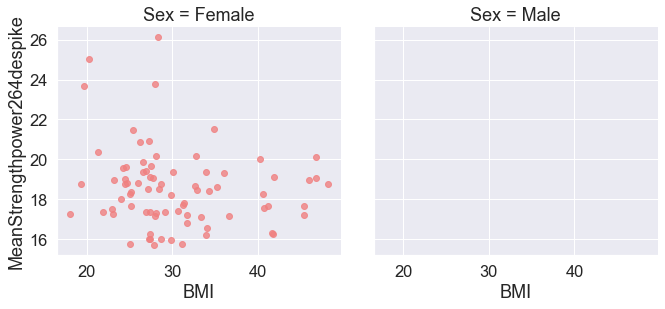

In [29]:
first = True
#Make data tables
df_temp = df.copy(deep=True)
for i,col in enumerate(df.columns.drop(['id0','id0.1','id0.2','id0.3','id0.4','id0.5','id0.6','id0.7','run_id','Age','Sex', 'BMI', 'datetime'])):   
    #create temporary dataframes for regression equations 
    graphedAgeSex = False #Flag to check if graph has already been generated
    graphedBMI = False #Flag to check if graph has already been generated
    AgeSex = True #Boolean for whether Age and Sex graphs or BMI and BxS graphs should be generated
    
    df_temp_Age = df_temp[df_temp['Age'].notna()]
    df_temp_Age = df_temp_Age[df_temp_Age[col].notna()]
    
    df_temp_Sex = df_temp[df_temp['Sex'].notna()]

    df_temp_Male = df_temp_Sex.copy(deep=True)
    df_temp_Male.drop(df_temp_Male.loc[df_temp_Male['Sex']=='Female'].index, inplace=True)
    df_temp_Male = df_temp_Male[df_temp_Male[col].notna()]

    df_temp_Female = df_temp_Sex.copy(deep=True)
    df_temp_Female.drop(df_temp_Female.loc[df_temp_Female['Sex']=='Male'].index, inplace=True)
    df_temp_Female = df_temp_Female[df_temp_Female[col].notna()]

    df_temp_BMI = df_temp[df_temp['BMI'].notna()]
    df_temp_BMI = df_temp_BMI[df_temp_BMI[col].notna()]
    
    df_temp_MaleMLR = df_temp_Male.copy(deep=True)
    df_temp_MaleMLR = df_temp_MaleMLR[df_temp_MaleMLR['Age'].notna()]
    df_temp_MaleMLR = df_temp_MaleMLR[df_temp_MaleMLR['BMI'].notna()]

    df_temp_FemaleMLR = df_temp_Female.copy(deep=True)
    df_temp_FemaleMLR = df_temp_FemaleMLR[df_temp_FemaleMLR['Age'].notna()]
    df_temp_FemaleMLR = df_temp_FemaleMLR[df_temp_FemaleMLR['BMI'].notna()]

    #Age
    if(df_temp_Age.size != 0):
        slope, intercept, r_value, p_value, std_err = st.linregress(df_temp_Age['Age'],df_temp_Age[col])
        write('Age', col,slope, intercept, r_value, p_value, std_err,flag = first)
        if(p_value<.05 and not graphedAgeSex):
            createGraph(col,AgeSex)
            graphedAgeSex = True

    #Sex
    if(df_temp_Male.size != 0 and df_temp_Female.size != 0 ):
        slope, intercept, r_value, p_value, std_err = st.linregress(df_temp_Male['Age'],df_temp_Male[col])
        slope2, intercept2, r_value2, p_value2, std_err2 = st.linregress(df_temp_Female['Age'],df_temp_Female[col])
        write('Sex', col, slope, intercept, r_value, p_value, std_err, 
                     slope2, intercept2, r_value2, p_value2, std_err2,flag = first)
        if((p_value<.05 or p_value2<.05) and not graphedAgeSex):
            createGraph(col, AgeSex)
            graphedAgeSex = True
    #BMI
    if(df_temp_BMI.size != 0):
        slope, intercept, r_value, p_value, std_err = st.linregress(df_temp_BMI['BMI'],df_temp_BMI[col])
        write('BMI', col,slope, intercept, r_value, p_value, std_err,flag = first)
        if(p_value<.05 and not graphedBMI):
            createGraph(col, not AgeSex)
            graphedBMI = True

    #BxS
    if(df_temp_Male.size != 0 and df_temp_Female.size != 0 ):
        slope, intercept, r_value, p_value, std_err = st.linregress(df_temp_Male['BMI'],df_temp_Male[col])
        slope2, intercept2, r_value2, p_value2, std_err2 = st.linregress(df_temp_Female['BMI'],df_temp_Female[col])
        write('BxS', col, slope, intercept, r_value, p_value, std_err, 
                      slope2, intercept2, r_value2, p_value2, std_err2,flag = first)
        if((p_value<.05 or p_value2<.05) and not graphedBMI):
            createGraph(col, not AgeSex)
            graphedBMI = True
    
    #Multiple Linear Regression, split by sex
    try:
        #Male
        mlr1 = LinearRegression()
        mlr1.fit(df_temp_MaleMLR[['Age', 'BMI']], df_temp_MaleMLR[col])
        intercept = mlr1.intercept_
        slope = mlr1.coef_
        r_value = mlr1.score(df_temp_MaleMLR[['Age', 'BMI']],df_temp_MaleMLR[col]) 

        #Female
        mlr2 = LinearRegression()
        mlr2.fit(df_temp_FemaleMLR[['Age', 'BMI']], df_temp_FemaleMLR[col])
        intercept2 = mlr2.intercept_
        slope2 = mlr2.coef_
        r_value2 = mlr2.score(df_temp_FemaleMLR[['Age', 'BMI']],df_temp_FemaleMLR[col])  

        write('MLR', col, slope, intercept, r_value, 0, 0, slope2, intercept2, r_value2, flag = first) #0,0 for p_value, stdErr
        
        if(r_value>0.1 or r_value2>0.1): #filter graph generation by R^2>0.1
            create3DGraph(col, r_value, r_value2, mlr1, mlr2)
    except ValueError:
        print(col)
    
    first = False      

KeyboardInterrupt: 

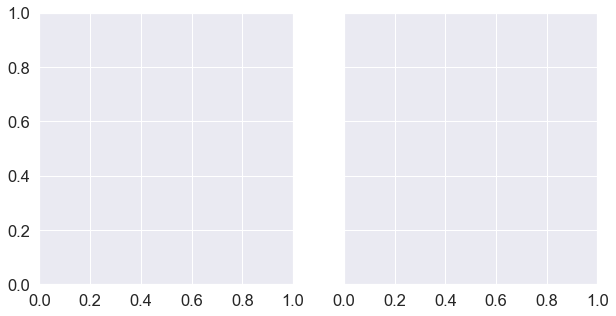

In [30]:
first = True
#Make data tables for measurements
for i,col in enumerate(df.columns.drop(['id0','id0.1','id0.2','id0.3','id0.4','id0.5','id0.6','id0.7','run_id','Age','Sex', 'BMI', 'datetime'])):   
    #create temporary dataframes for regression equations 
    df_temp = df.copy(deep=True)
    df_temp = df_temp[df_temp[col].notna()]
    df_temp = df_temp[df_temp['peakvo2_ml_gxt'].notna()]
    df_temp = df_temp[df_temp['fft_4step_t1'].notna()]
    df_temp = df_temp[df_temp['fft_4step_t2'].notna()]
    df_temp = df_temp[df_temp['fft_stair_ds_tester1'].notna()]
    df_temp = df_temp[df_temp['fft_stair_us_tester1'].notna()]
    df_temp_Sex = df_temp[df_temp['Sex'].notna()]


    df_temp_Male = df_temp_Sex.copy(deep=True)
    df_temp_Male.drop(df_temp_Male.loc[df_temp_Male['Sex']=='Female'].index, inplace=True)

    df_temp_Female = df_temp_Sex.copy(deep=True)
    df_temp_Female.drop(df_temp_Female.loc[df_temp_Female['Sex']=='Male'].index, inplace=True)
    
    cols = []
    
    if(df_temp.size != 0):
        #vo2
        slope, intercept, r_value, p_value, std_err = st.linregress(df_temp['peakvo2_ml_gxt'], df_temp[col])
        write('V_O2', col,slope, intercept, r_value, p_value, std_err,flag = first)
        if(p_value<.05):
            cols.append('peakvo2_ml_gxt')
            
        #four1
        slope, intercept, r_value, p_value, std_err = st.linregress(df_temp['fft_4step_t1'],df_temp[col])
        write('four1', col,slope, intercept, r_value, p_value, std_err,flag = first)
        if(p_value<.05 ):
            cols.append('fft_4step_t1')
            
        #four2
        slope, intercept, r_value, p_value, std_err = st.linregress(df_temp['fft_4step_t2'],df_temp[col])
        write('four2', col,slope, intercept, r_value, p_value, std_err,flag = first)
        if(p_value<.05 ):
            cols.append('fft_4step_t2')
            
        #stairDown
        slope, intercept, r_value, p_value, std_err = st.linregress(df_temp['fft_stair_ds_tester1'],df_temp[col])
        write('stairDown', col,slope, intercept, r_value, p_value, std_err,flag = first)
        if(p_value<.05 ):
            cols.append('fft_stair_ds_tester1')
            
        #stairUp
        slope, intercept, r_value, p_value, std_err = st.linregress(df_temp['fft_stair_us_tester1'],df_temp[col])
        write('stairUp', col,slope, intercept, r_value, p_value, std_err,flag = first)
        if(p_value<.05 ):
            cols.append('fft_stair_us_tester1')
            
            
            
    if(df_temp_Male.size != 0 and df_temp_Female.size != 0 ):
        #vo2
        slope, intercept, r_value, p_value, std_err = st.linregress(df_temp_Male['peakvo2_ml_gxt'],df_temp_Male[col])
        slope2, intercept2, r_value2, p_value2, std_err2 = st.linregress(df_temp_Female['peakvo2_ml_gxt'],df_temp_Female[col])
        write('V_O2_Sex', col, slope, intercept, r_value, p_value, std_err, 
                     slope2, intercept2, r_value2, p_value2, std_err2,flag = first)
        if (p_value<.05 or p_value2<.05) and 'peakvo2_ml_gxt' not in cols:
            cols.append('peakvo2_ml_gxt')

        #four1
        slope, intercept, r_value, p_value, std_err = st.linregress(df_temp_Male['fft_4step_t1'],df_temp_Male[col])
        slope2, intercept2, r_value2, p_value2, std_err2 = st.linregress(df_temp_Female['fft_4step_t1'],df_temp_Female[col])
        write('four1_Sex', col, slope, intercept, r_value, p_value, std_err, 
                     slope2, intercept2, r_value2, p_value2, std_err2,flag = first)
        if(p_value<.05 or p_value2<.05) and 'fft_4step_t1' not in cols:
            cols.append('fft_4step_t1')
            
        #four2
        slope, intercept, r_value, p_value, std_err = st.linregress(df_temp_Male['fft_4step_t2'],df_temp_Male[col])
        slope2, intercept2, r_value2, p_value2, std_err2 = st.linregress(df_temp_Female['fft_4step_t2'],df_temp_Female[col])
        write('four2_Sex', col, slope, intercept, r_value, p_value, std_err, 
                     slope2, intercept2, r_value2, p_value2, std_err2,flag = first)
        if(p_value<.05 or p_value2<.05) and 'fft_4step_t2' not in cols:
            cols.append('fft_4step_t2')

        #stairDown
        slope, intercept, r_value, p_value, std_err = st.linregress(df_temp_Male['fft_stair_ds_tester1'],df_temp_Male[col])
        slope2, intercept2, r_value2, p_value2, std_err2 = st.linregress(df_temp_Female['fft_stair_ds_tester1'],df_temp_Female[col])
        write('stairDown_Sex', col, slope, intercept, r_value, p_value, std_err, 
                     slope2, intercept2, r_value2, p_value2, std_err2,flag = first)
        if(p_value<.05 or p_value2<.05) and 'fft_stair_ds_tester1' not in cols:
            cols.append('fft_stair_ds_tester1')
            
        #stairUp
        slope, intercept, r_value, p_value, std_err = st.linregress(df_temp_Male['fft_stair_us_tester1'],df_temp_Male[col])
        slope2, intercept2, r_value2, p_value2, std_err2 = st.linregress(df_temp_Female['fft_stair_us_tester1'],df_temp_Female[col])
        write('stairUp_Sex', col, slope, intercept, r_value, p_value, std_err, 
                     slope2, intercept2, r_value2, p_value2, std_err2, flag = first)
        if(p_value<.05 or p_value2<.05) and 'fft_stair_us_tester1' not in cols:
            cols.append('fft_stair_us_tester1')
        
        createBehavioralGraph(col,cols)
        
    first = False      

In [31]:
#create descriptions for different variables using keywords, return corresponding string
def desc(name):
    if('snrd' in name):
        return 'Dietrich’s SNR using air background as reference:<span style="color: green"> &#8593</span>'
    elif('snr' in name or 'tsnr' in name):
        return 'Signal-to-Noise ratio:<span style="color: green"> &#8593</span>'
    elif('cnr' in name):
        return 'Contrast-to-noise ratio:<span style="color: green"> &#8593</span>'
    elif('fwhm' in name):
        return 'Full-width half maximum estimations:<span style="color: green"> &#8595</span>'
    elif('qi2' in name):
        return 'Goodness of fit of a noise model into the background noise: <span style="color: green">&#8595</span>'
    elif('cjv' in name):
        return 'Coefficient of joint variation:<span style="color: green"> &#8595</span>'
    elif(name.startswith('efc')):
        return """Entropy focus criterion:
        <span style="color: green"> &#8595 more uniform distribution, less noisy</span>"""
    elif('fber' in name):
        return 'Foreground-background energy ratio:<span style="color: green"> &#8593</span>'
    elif('qi1' in name):
        return 'Segmentation using mathematical morphology:<span style="color: green"> &#8595</span>'
    elif('inu' in name):
        return 'Intensity non-uniformity estimate measurements:<span style="color: green"> ~1</span>'
    elif('pve' in name):
        return 'Partial volume errors:<span style="color: green"> &#8595</span>'
    elif('wm2max' in name):
        return 'White-matter to maximum intensity ratio:<span style="color: green"> [0.6, 0.8]</span>'
    elif('icv' in name):
        return 'Intracranial volume fractions: <span style="color: green"> “should move within a normative range”</span>'
    elif('rpve' in name):
        return 'Residual partial volume errors:<span style="color: green"> &#8595</span>'
    elif('fd' in name):
        return 'Framewise displacement:<span style="color: green"> &#8595</span>'
    elif('dvars' in name):
        return 'Temporal derivative of timecourses RMS variance over voxels:<span style="color: green"> &#8595</span>'
    elif('gsr' in name):
        return 'Ghost-to-signal Ratio:<span style="color: green"> &#8595</span>'
    elif('gcor' in name):
        return 'Global correlation :<span style="color: green"> &#8595</span>'
    elif('spikes' in name):
        return 'High frequency and global intensity :<span style="color: green"> &#8595 (lessvolumes to remove if filtering)</span>'
    elif('aor' in name):
        return 'AFNI’s outlier ratio: mean fraction of outliers per fMRI volume'
    elif('aqi' in name):
        return 'AFNI’s quality index: mean quality index'
    elif('coregCrossCorr' in name):
        return 'Cross correlation:<span style="color: green"> &#8593</span>'
    elif('CoregJaccard' in name):
        return 'Jaccard index:<span style="color: green"> &#8593</span>'
    elif('CoregDice' in name):
        return 'Dice index:<span style="color: green"> &#8593</span>'
    elif('CoregCoverage' in name):
        return 'Coverage index:<span style="color: green"> &#8593</span>'
    elif('regCrossCorr' in name):
        return 'Cross correlation:<span style="color: green"> &#8593</span>'
    elif('regJaccard' in name):
        return 'Jaccard index:<span style="color: green"> &#8593</span>'
    elif('regDice' in name):
        return 'Dice index:<span style="color: green"> &#8593</span>'
    elif('regCoverage' in name):
        return 'Coverage index:<span style="color: green"> &#8593</span>'
    elif('normCrossCorr' in name):
        return 'Cross correlation:<span style="color: green"> &#8593</span>'
    elif('normJaccard' in name):
        return 'Jaccard index:<span style="color: green"> &#8593</span>'
    elif('normDice' in name):
        return 'Dice index:<span style="color: green"> &#8593</span>'
    elif('normCoverage' in name):
        return 'Coverage index:<span style="color: green"> &#8593</span>'
    elif('relMeanRMSMotion' in name):
        return 'Mean value of RMS motion:<span style="color: green"> &#8595</span>'
    elif('relMaxRMSMotion' in name):
        return 'Maximum value of RMS motion:<span style="color: green"> &#8595</span>'
    elif('nSpikesFD' in name):
        return 'Number of spikes per FD:<span style="color: green"> &#8595</span>'
    elif('nspikesDV' in name):
        return 'Number of spikes per DV:<span style="color: green"> &#8595</span>'
    elif('pctSpikesDV' in name):
        return 'Percentage of spikes per DV:<span style="color: green"> &#8595</span>'
    elif('pctSpikesFD' in name):
        return 'Percentage of spikes per DV:<span style="color: green"> &#8595/span>'
    elif('meanDV' in name):
        return 'Mean DVARS:<span style="color: green"> &#8595</span>'
    elif('motionDVCorrInit' in name):
        return 'Correlation of RMS and DVARS before regression:<span style="color: green"> &#8595</span>'
    elif('motionDVCorrFinal' in name):
        return 'Correlation of RMS and DVARS after regression :<span style="color: green"> &#8595 lower than init</span>'
    elif('nNuisanceParameters' in name):
        return 'Total number of nuisance Parameters in addition to custom regressors:<span style="color: green"> &#8595</span> (confound regression model-dependent)'
    elif('nVolCensored' in name):
        return 'Total number of volume(s) censored:<span style="color: green"> &#8595</span>'
    elif('estimatedLostTemporalDOF' in name):
        return 'Total degree of freedom lost:<span style="color: green"> &#8595</span>'
    elif('mean_fd' in name):
        return 'Mean framewise displacement:<span style="color: green"> &#8595</span>'
    elif('max_fd' in name):
        return 'Maximum framewise displacement:<span style="color: green"> &#8595</span>'
    elif('max_translation' in name):
        return '<span style="color: green"> &#8595</span>'
    elif('max_rotation' in name):
        return '<span style="color: green"> &#8595</span>'
    elif('max_rel_translation' in name):
        return 'Maxima of derivative of max_translation:<span style="color: green"> &#8595</span>'
    elif('max_rel_rotation' in name):
        return 'Maxima of derivative of max_rotation:<span style="color: green"> &#8595</span>'
    elif('t1_dice_distance' in name):
        return '<span style="color: green"> &#8593</span>'
    elif('mni_dice_distance' in name):
        return '<span style="color: green"> &#8593</span>'
    elif('raw_incoherence_index ' in name):
        return '<span style="color: green"> &#8595</span>'
    elif('raw_coherence_index ' in name):
        return '<span style="color: green"> &#8593</span>'
    elif('t1_incoherence_index ' in name):
        return '<span style="color: green"> &#8595</span>'
    elif('t1_coherence_index ' in name):
        return '<span style="color: green"> &#8593</span>'
    elif('num_bad_slices' in name):
        return '<span style="color: green"> &#8595</span>'
    elif('raw_dimension' in name):
        return 'Should match protocol field of view'
    elif('raw_voxel_size' in name):
        return 'Should match protocol resolution'
    elif('raw_max_b' in name):
        return 'Should match protocol maximum b'
    elif('raw_neighbor_corr' in name):
        return 'Neighboring DWI Correlation (NDC)'
    elif('raw_num_directions' in name):
        return 'Should match protocol number of directions for dwi scan'
    elif('t1_dimension' in name):
        return 'Preprocessed space field of view'
    elif('t1_voxel_size' in name):
        return 'Preprocessed space resolution controlled by --output_resolution value'
    if('t1_max_b' in name):
        return 'Equal to raw_max_b'
    elif('t1_neighbor_corr' in name):
        return 'Equal to raw_neighbor_corr'
    elif('t1_num_directions' in name):
        return 'Equal to raw_num_directions'
    else:
        return ""

In [32]:
def mean(name):
    return str(df[name].mean())

# In[12]:
def median(name):
    return str(df[name].median())

# In[13]:
def std(name):
    return str(df[name].std())

# In[14]:
def rnge(name):
    return str(df[name].max() - df[name].min())

# In[15]:
def outliers(name):
    flag = False
    outs = ""
    mean_ = float(mean(name))
    std_ = float(std(name))
    for i in df.index:
        if((mean_-2*std_)>df[name][i] or df[name][i]>(mean_+2*std_)):
            if(flag):
                outs += ", "+ str(df['id0'][i])
                if df['id0'][i] in list_outliers:
                    list_outliers[df['id0'][i]].append(name)
                else:
                    list_outliers[df['id0'][i]] = [name]    
            else:
                outs += str(df['id0'][i])
                flag = True
                if df['id0'][i] in list_outliers:
                    list_outliers[df['id0'][i]].append(name)
                else:
                    list_outliers[df['id0'][i]] = [name] 
                
    return outs

# In[16]:
def get_outliers():
    output = ""
    #remove nan key to sort keys in ascending order
    removed = 0;
    for key in list_outliers.keys():
        if type(key)==float:
            removed=key
            break
     #add nan key entry to return string
    output += "<div class = outliers><br><h2>"+str(removed) + "</h2><h3> (" +str(len(list_outliers.get(removed)))+" occurences):</h3><br>"
    flag = False
    for item in list_outliers.get(removed):
        if flag:
            output += ", "+ str(item)
        else:
            output += str(item)
            flag = True
    
    outliers = {k: list_outliers[k] for k in list_outliers if type(k)==str}
    for key in sorted(outliers):
        output += "<div class = outliers><br><h2>"+str(key) + "</h2><h3> (" +str(len(list_outliers.get(key)))+" occurences):</h3><br>"
        flag = False
        for item in outliers.get(key):
            if flag:
                output += ", "+ str(item)
            else:
                output += str(item)
                flag = True
        output += "</div>"
    output += "</div>"
    return output

In [33]:
#List of graph tags
tags = ["Sex","Age","BMI","BxS","_3D"]

In [34]:
#CSS - In-document styling sheet for each site
#dropdown menu from https://www.w3schools.com/howto/howto_css_dropdown.asp
css = """ body{
        margin:0;
    }
    .row {
        display: flex;
    }
    .column {
        flex: 50%;
        padding: 5px;
    }
    table, th, td {
      border: 1px solid black;
      border-collapse: collapse;
    }
    
   
    .image1 {
        display: flex;
        justify-content: center;
        
    }
    .navbar {
      overflow: hidden;
      background-color: #13294b;
    }

    .navbar a {
      float: left;
      font-size: 16px;
      color: white;
      text-align: center;
      padding: 14px 16px;
      text-decoration: none;
    }
    
    .active{
        background-color: #E84A27;
    }

    .dropdown {
      float: left;
      overflow: hidden;
    }

    .dropdown .dropbtn {
      font-size: 16px;  
      border: none;
      outline: none;
      color: white;
      padding: 14px 16px;
      background-color: #13294b;
      font-family: inherit;
      margin: 0;
    }

    .navbar a:hover, .dropdown:hover .dropbtn {
      background-color: #E8E9EA;
    }

    .dropdown-content {
      display: none;
      position: absolute;
      background-color: #13294b;
      min-width: 160px;
      box-shadow: 0px 8px 16px 0px rgba(0,0,0,0.2);
      z-index: 1;
    }

    .dropdown-content a {
      float: none;
      color: white;
      padding: 12px 16px;
      text-decoration: none;
      display: block;
      text-align: left;
    }

    .dropdown-content a:hover {
      background-color: #E8E9EA;
    }

    .dropdown:hover .dropdown-content {
      display: block;
    }

    #searchbar{
     padding:13px;
     border-radius: 10px;
   }
 
   input[type=text] {
      width: 7%;
      -webkit-transition: width 0.15s ease-in-out;
      transition: width 0.15s ease-in-out;
   }
   input[type=text]:focus {
     width: 15%;
   }
   """



In [41]:
list_outliers.clear()

main_name = study_name+"QCGraphs.html"
f = open(main_name,'w') #create QCGraphs in local folder

grphs = ""
for filename in os.listdir(os.getcwd()):
    if filename.endswith(".png") and filename != "Illini_icon.png" and filename != "heatmap_total.png" and filename != "heatmap_95.png":
        #descriptive stats
        cont = True
        name = filename[:len(filename) - 4]
        #Check if Age and Sex Graphs exist; if not, should be in BMI page
        if not(os.path.exists(name+"_Age.png") or os.path.exists(name+"_Sex.png")):
            continue
        exclude = ["_Age", "_Sex","_BMI", "_BxS", "_peakvo2_ml_gxt", "_fft_4step_t1", "_fft_4step_t2", "_fft_stair_ds_tester1", "_fft_stair_us_tester1" ]
        #Check if png should not be on this page
        for item in exclude:
            if (item in name): 
                cont = False
        if not cont:
            continue

        _stats = """<table style="width:50% ">
                  <tr>
                    <th colspan="2">"""+name+"""</th>
                  </tr>
                  <tr>
                    <td>Mean</td>
                    <td>"""+mean(name)+"""</td>
                  </tr>
                   <tr>
                    <td>Median</td>
                    <td>"""+median(name)+"""</td>
                  </tr>
                   <tr>
                    <td>Std.</td>
                    <td>"""+std(name)+"""</td>
                  </tr>
                   <tr>
                    <td>Range</td>
                    <td>"""+rnge(name)+"""</td>
                  </tr>
                </table>"""
        
        #Insert sets of 3 graphs in template to ensure graph stays with corresponding age and sex graphs
        grphs += "<div class=row>"
        grphs += ("<div class=column><h2 style='text-align:center'>"+name+"_Age</h2><div class='image1'><img src="+ name
                  +"_Age.png>\n</div></i></p></div>")
        grphs+= ("<div class=column><h2 style='text-align:center'>"+name+"</h2><div class='image1'><img src="+ filename+
            " >\n</div><br><p font-style=italic align=center><i>"+_stats+ 
            "<br><font size='+2'>" +str(desc(name))+
            "</font><br>Outliers: "+outliers(name)+"</i></p></div>")
        grphs += ("<div class=column><h2 style='text-align:center'>"+name+"_Sex</h2><div class='image1'><img src="+ name +
            "_Sex.png>\n</div></i></p></div>")
        grphs += "</div>"
    else:
        continue

#linked stylesheet for caret symbol for dropdown        
code = """<html><link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/font-awesome/4.7.0/css/font-awesome.min.css">
<style>"""+css+"""</style>
<meta name="robots" content="noindex">
<head>
    <div class="navbar">
        <a class="active" href="""+study_name+"""QCGraphs.html>QC Graphs</a>
        <a href="""+study_name+"""nbs_qsiGraphs.html> NBS QSI </a>
        <a href="""+study_name+"""nbs_RSFC.html> NBS RSFC</a>
        <a href="""+study_name+"""func_restGraphs.html> Functional Resting-State</a>
        <a href="""+study_name+"""diff_qcGraphs.html> Diffusion QC </a>
        <a href="""+study_name+"""t1wGraphs.html> T1 Weighted </a>
        <a href="""+study_name+"""t2wGraphs.html> T2 Weighted </a>
        <div class="dropdown">
            <button class="dropbtn">Behavioral Graphs 
              <i class="fa fa-caret-down"></i>
            </button>
            <div class="dropdown-content">
            <a href="""+study_name+"""vo2Graphs.html> Peak VO2 </a>
            <a href="""+study_name+"""fourStep1Graphs.html> FourStep 1 </a>
            <a href="""+study_name+"""fourStep2Graphs.html> FourStep 2 </a>
            <a href="""+study_name+"""stairDownGraphs.html> Stair-Down </a>
            <a href="""+study_name+"""stairUpGraphs.html> Stair-Up </a>
          </div>
        </div>
        <a href="""+study_name+"""outliers.html>Outliers</a>
        <a href="""+study_name+"""data.html>Data</a>
        <a href="""+study_name+"""about.html>About</a>
        <img src="Illini_icon.png" width = 3.5% style="float:right">
        <input id="searchbar" onkeyup="Search_var()" type="text" name="search" placeholder="Search...">
    </div>
    
</head>
"""
f.write(code)

#insert graphs
code2 = """

<body style="background-color:#f0f0f0">

<div style = "text-align: center; vertical-align: middle;">
<h1>Last Updated: """+date+"""</h1>
</div>

"""+grphs+"""</body> 

<script>
function Search_var() {
    let input = document.getElementById('searchbar').value
    input=input.toLowerCase();
    let x = document.getElementsByClassName('row');
     
    for (i = 0; i < x.length; i++) {
        if (!x[i].innerHTML.toLowerCase().includes(input)) {
            x[i].style.display="none";
        }
        else {
            x[i].style.display="";                
        }
    }
}
</script>
</html>"""


f.write(code2)
f.close()

#open html file
QCfile = 'file:///'+os.getcwd()+'/' + main_name
webbrowser.open_new_tab(QCfile)

True

In [36]:
BMI_name = study_name+"BMIGraphs.html"
f = open(BMI_name,'w') #create BMIGraphs in local folder

grphs = ""
for filename in os.listdir(os.getcwd()):
    if filename.endswith(".png") and filename != "Illini_icon.png" and filename != "heatmap_total.png" and filename != "heatmap_95.png":
        #descriptive stats
        name = filename[:len(filename) - 4]
        #Check if Age and Sex Graphs exist; if not, should be in BMI page
        if not(os.path.exists(name+"_BMI.png") or os.path.exists(name+"_BxS.png")):
            continue
        exclude = ["_Age", "_Sex","_BMI", "_BxS", "_peakvo2_ml_gxt", "_fft_4step_t1", "fft_4step_t2", "_fft_stair_ds_tester1", "_fft_stair_us_tester1" ]
        #Check if png should not be on this page
        for item in exclude:
            if (item in name): 
                cont = False
        if not cont:
            continue
        _stats = """<table style="width:50% ">
                  <tr>
                    <th colspan="2">"""+name+"""</th>
                  </tr>
                  <tr>
                    <td>Mean</td>
                    <td>"""+mean(name)+"""</td>
                  </tr>
                   <tr>
                    <td>Median</td>
                    <td>"""+median(name)+"""</td>
                  </tr>
                   <tr>
                    <td>Std.</td>
                    <td>"""+std(name)+"""</td>
                  </tr>
                   <tr>
                    <td>Range</td>
                    <td>"""+rnge(name)+"""</td>
                  </tr>
                </table>"""
        
        #Insert sets of 2 graphs in template to ensure graph stays with corresponding age and sex graphs
        grphs += "<div class=row>"
        grphs += ("<div class=column><h2 style='text-align:center'>"+name+"_BMI</h2><div class='image1'><img src="+ name +
            "_BMI.png>\n</div></i></p></div>")
        grphs+= ("<div class=column><h2 style='text-align:center'>"+name+"</h2><div class='image1'><img src="+ filename+
            " >\n</div><br><p font-style=italic align=center><i>"+_stats+ 
            "<br><font size='+2'>" +str(desc(name))+
            "</font><br>Outliers: "+outliers(name)+"</i></p></div>")
        grphs += ("<div class=column><h2 style='text-align:center'>"+name+"_BMIbySex</h2><div class='image1'><img src="+ name +
            "_BxS.png>\n</div></i></p></div>")
        grphs += "</div>"
    else:
        continue

#linked stylesheet for caret symbol for dropdown        
code = """<html><link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/font-awesome/4.7.0/css/font-awesome.min.css">
<style>"""+css+"""</style>
<meta name="robots" content="noindex">
<head>

    <div class="navbar">
        <a href="""+study_name+"""QCGraphs.html>QC Graphs</a>
        <a href="""+study_name+"""nbs_qsiGraphs.html> NBS QSI </a>
        <a href="""+study_name+"""nbs_fc36pGraphs.html> NBS fc36p </a>
        <a href="""+study_name+"""func_restGraphs.html> Functional Resting-State</a>
        <a href="""+study_name+"""diff_qcGraphs.html> Diffusion QC </a>
        <a href="""+study_name+"""t1wGraphs.html> T1 Weighted </a>
        <a href="""+study_name+"""t2wGraphs.html> T2 Weighted </a>
        <div class="dropdown">
            <button class="dropbtn">Behavioral Graphs 
              <i class="fa fa-caret-down"></i>
            </button>
            <div class="dropdown-content">
            <a href="""+study_name+"""vo2Graphs.html> Peak VO2 </a>
            <a href="""+study_name+"""fourStep1Graphs.html> FourStep 1 </a>
            <a href="""+study_name+"""fourStep2Graphs.html> FourStep 2 </a>
            <a href="""+study_name+"""stairDownGraphs.html> Stair-Down </a>
            <a href="""+study_name+"""stairUpGraphs.html> Stair-Up </a>
          </div>
        </div>
        <a href="""+study_name+"""outliers.html>Outliers</a>
        <a href="""+study_name+"""data.html>Data</a>
        <a href="""+study_name+"""about.html>About</a>
        <img src="Illini_icon.png" width = 3.5% style="float:right">
        <input id="searchbar" onkeyup="Search_var()" type="text" name="search" placeholder="Search...">
    </div>
    
</head>
"""
f.write(code)

#insert graphs
code2 = """

<body style="background-color:#f0f0f0">

<div style = "text-align: center; vertical-align: middle;">
<h1>Last Updated: """+date+"""</h1>
</div>

"""+grphs+"""</body> 

<script>
function Search_var() {
    let input = document.getElementById('searchbar').value
    input=input.toLowerCase();
    let x = document.getElementsByClassName('row');
     
    for (i = 0; i < x.length; i++) {
        if (!x[i].innerHTML.toLowerCase().includes(input)) {
            x[i].style.display="none";
        }
        else {
            x[i].style.display="";                
        }
    }
}
</script>
</html>"""


f.write(code2)
f.close()

In [37]:
nbs_qsi_name = study_name+"nbs_qsiGraphs.html"
f = open(nbs_qsi_name,'w') #create nbs_qsiGraphs in local folder

grphs = ""
for filename in os.listdir(os.getcwd()):
    if filename.endswith(".png") and filename != "Illini_icon.png" and filename != "heatmap_total.png" and filename != "heatmap_95.png":
        #descriptive stats
        name = filename[:len(filename) - 4]
        if (not('AAL116SC' in name)):
            continue
        end = name[len(name) - 3:len(name)]
        if(end in tags):
            continue
        _stats = """<table style="width:90%">
                  <tr>
                    <th colspan="2">"""+name+"""</th>
                  </tr>
                  <tr>
                    <td>Mean</td>
                    <td>"""+mean(name)+"""</td>
                  </tr>
                   <tr>
                    <td>Median</td>
                    <td>"""+median(name)+"""</td>
                  </tr>
                   <tr>
                    <td>Std.</td>
                    <td>"""+std(name)+"""</td>
                  </tr>
                   <tr>
                    <td>Range</td>
                    <td>"""+rnge(name)+"""</td>
                  </tr>
                </table>"""
        
        #Insert sets of 2 graphs in template to ensure graph stays with corresponding age and sex graphs
        grphs += "<div class=row>"
        grphs+= ("<div class=column><h3 style='text-align:center'>"+name+": Age</h3><div class='image1'><img src="+ name+
            "_Age.png>\n</div></i></p></div>")
        grphs+= ("<div class=column><h1 style='text-align:center'>"+name+"</h1><div class='image1'><img src="+ filename+
            " width='600'>\n</div><br><p font-style=italic align=center><i>"+_stats+ 
            "<br><font size='+2'>" +str(desc(name))+
            "</font><br>Outliers: "+outliers(name)+"</i></p></div>")
        grphs += ("<div class=column><h3 style='text-align:center'>"+name+": Sex</h3><div class='image1'><img src="+ name +
            "_Sex.png>\n</div></i></p></div>")
        grphs += "</div><div class=row>"
        grphs+= ("<div class=column><h3 style='text-align:center'>"+name+": BMI</h3><div class='image1'><img src="+ name+
            "_BMI.png>\n</div></i></p></div>")
        grphs+= ("<div class=column><h3 style='text-align:center'>"+name+": BMI by Sex</h3><div class='image1'><img src="+ name+
            "_BxS.png>\n</div></i></p></div>")
        grphs += ("<div class=column><h3 style='text-align:center'>"+name+": 3D</h3><div class='image1'><img src="+ name +
            "_3D.png>\n</div></i></p></div>")
        grphs += "</div>"
        grphs += "<div style='border-bottom:double'></div>"
    else:
        continue

#linked stylesheet for caret symbol for dropdown        
code = """<html><link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/font-awesome/4.7.0/css/font-awesome.min.css">
<style>"""+css+"""</style>
<meta name="robots" content="noindex">
<head>
    <div class="navbar">
        <a href="""+study_name+"""QCGraphs.html>QC Graphs</a>
        <a class="active" href="""+study_name+"""nbs_qsiGraphs.html> NBS QSI </a>
        <a href="""+study_name+"""nbs_RSFC.html> NBS RSFC</a>
        <a href="""+study_name+"""func_restGraphs.html> Functional Resting-State</a>
        <a href="""+study_name+"""diff_qcGraphs.html> Diffusion QC </a>
        <a href="""+study_name+"""t1wGraphs.html> T1 Weighted </a>
        <a href="""+study_name+"""t2wGraphs.html> T2 Weighted </a>
        <div class="dropdown">
            <button class="dropbtn">Behavioral Graphs 
              <i class="fa fa-caret-down"></i>
            </button>
            <div class="dropdown-content">
            <a href="""+study_name+"""vo2Graphs.html> Peak VO2 </a>
            <a href="""+study_name+"""fourStep1Graphs.html> FourStep 1 </a>
            <a href="""+study_name+"""fourStep2Graphs.html> FourStep 2 </a>
            <a href="""+study_name+"""stairDownGraphs.html> Stair-Down </a>
            <a href="""+study_name+"""stairUpGraphs.html> Stair-Up </a>
          </div>
        </div>
        <a href="""+study_name+"""outliers.html>Outliers</a>
        <a href="""+study_name+"""data.html>Data</a>
        <a href="""+study_name+"""about.html>About</a>
        <img src="Illini_icon.png" width = 3.5% style="float:right">
        <input id="searchbar" onkeyup="Search_var()" type="text" name="search" placeholder="Search...">
    </div>
</head>
"""
f.write(code)

#insert graphs
code2 = """

<body style="background-color:#f0f0f0">

<div style = "text-align: center; vertical-align: middle;">
<h1>Last Updated: """+date+"""</h1>
</div>

"""+grphs+"""</body> 

<script>
function Search_var() {
    let input = document.getElementById('searchbar').value
    input=input.toLowerCase();
    let x = document.getElementsByClassName('row');
     
    for (i = 0; i < x.length; i++) {
        if (!x[i].innerHTML.toLowerCase().includes(input)) {
            x[i].style.display="none";
        }
        else {
            x[i].style.display="";                
        }
    }
}
</script>
</html>"""


f.write(code2)
f.close()



In [38]:
diff_qc_name = study_name+"diff_qcGraphs.html"
f = open(diff_qc_name,'w') #create diff_qcGraphs in local folder

grphs = ""
for filename in os.listdir(os.getcwd()):
    if filename.endswith(".png") and filename != "Illini_icon.png" and filename != "heatmap_total.png" and filename != "heatmap_95.png":
        #descriptive stats
        name = filename[:len(filename) - 4]
        if (not('raw_' in name or 't1_' in name or 'mean_fd' in name 
               or 'max_fd' in name or 'max_rotation' in name 
               or 'max_translation' in name or 'max_rel_' in name 
               or 'acq_id' in name) or 'fft' in name):
            continue
        end = name[len(name) - 3:len(name)]
        if(end in tags):
            continue
        _stats = """<table style="width:90%">
                  <tr>
                    <th colspan="2">"""+name+"""</th>
                  </tr>
                  <tr>
                    <td>Mean</td>
                    <td>"""+mean(name)+"""</td>
                  </tr>
                   <tr>
                    <td>Median</td>
                    <td>"""+median(name)+"""</td>
                  </tr>
                   <tr>
                    <td>Std.</td>
                    <td>"""+std(name)+"""</td>
                  </tr>
                   <tr>
                    <td>Range</td>
                    <td>"""+rnge(name)+"""</td>
                  </tr>
                </table>"""
        
        #Insert sets of 2 graphs in template to ensure graph stays with corresponding age and sex graphs
        grphs += "<div class=row>"
        grphs+= ("<div class=column><h3 style='text-align:center'>"+name+": Age</h3><div class='image1'><img src="+ name+
            "_Age.png>\n</div></i></p></div>")
        grphs+= ("<div class=column><h1 style='text-align:center'>"+name+"</h1><div class='image1'><img src="+ filename+
            " width='600'>\n</div><br><p font-style=italic align=center><i>"+_stats+ 
            "<br><font size='+2'>" +str(desc(name))+
            "</font><br>Outliers: "+outliers(name)+"</i></p></div>")
        grphs += ("<div class=column><h3 style='text-align:center'>"+name+": Sex</h3><div class='image1'><img src="+ name +
            "_Sex.png>\n</div></i></p></div>")
        grphs += "</div><div class=row>"
        grphs+= ("<div class=column><h3 style='text-align:center'>"+name+": BMI</h3><div class='image1'><img src="+ name+
            "_BMI.png>\n</div></i></p></div>")
        grphs+= ("<div class=column><h3 style='text-align:center'>"+name+": BMI by Sex</h3><div class='image1'><img src="+ name+
            "_BxS.png>\n</div></i></p></div>")
        grphs += ("<div class=column><h3 style='text-align:center'>"+name+": 3D</h3><div class='image1'><img src="+ name +
            "_3D.png>\n</div></i></p></div>")
        grphs += "</div>"
        grphs += "<div style='border-bottom:double'></div>"
    else:
        continue

#linked stylesheet for caret symbol for dropdown        
code = """<html><link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/font-awesome/4.7.0/css/font-awesome.min.css">
<style>"""+css+"""</style>
<meta name="robots" content="noindex">
<head>
    <div class="navbar">
        <a href="""+study_name+"""QCGraphs.html>QC Graphs</a>
        <a href="""+study_name+"""nbs_qsiGraphs.html> NBS QSI </a>
        <a href="""+study_name+"""nbs_RSFC.html> NBS RSFC</a>
        <a href="""+study_name+"""func_restGraphs.html> Functional Resting-State</a>
        <a class="active" href="""+study_name+"""diff_qcGraphs.html> Diffusion QC </a>
        <a href="""+study_name+"""t1wGraphs.html> T1 Weighted </a>
        <a href="""+study_name+"""t2wGraphs.html> T2 Weighted </a>
        <div class="dropdown">
            <button class="dropbtn">Behavioral Graphs 
              <i class="fa fa-caret-down"></i>
            </button>
            <div class="dropdown-content">
            <a href="""+study_name+"""vo2Graphs.html> Peak VO2 </a>
            <a href="""+study_name+"""fourStep1Graphs.html> FourStep 1 </a>
            <a href="""+study_name+"""fourStep2Graphs.html> FourStep 2 </a>
            <a href="""+study_name+"""stairDownGraphs.html> Stair-Down </a>
            <a href="""+study_name+"""stairUpGraphs.html> Stair-Up </a>
          </div>
        </div>
        <a href="""+study_name+"""outliers.html>Outliers</a>
        <a href="""+study_name+"""data.html>Data</a>
        <a href="""+study_name+"""about.html>About</a>
        <img src="Illini_icon.png" width = 3.5% style="float:right">
        <input id="searchbar" onkeyup="Search_var()" type="text" name="search" placeholder="Search...">
    </div>
</head>
"""
f.write(code)

#insert graphs
code2 = """

<body style="background-color:#f0f0f0">

<div style = "text-align: center; vertical-align: middle;">
<h1>Last Updated: """+date+"""</h1>
</div>

"""+grphs+"""</body> 

<script>
function Search_var() {
    let input = document.getElementById('searchbar').value
    input=input.toLowerCase();
    let x = document.getElementsByClassName('row');
     
    for (i = 0; i < x.length; i++) {
        if (!x[i].innerHTML.toLowerCase().includes(input)) {
            x[i].style.display="none";
        }
        else {
            x[i].style.display="";                
        }
    }
}
</script>
</html>"""


f.write(code2)
f.close()

KeyError: 'max_fd_peakvo2_ml_gxt'

In [ ]:
t1w_name = study_name+"t1wGraphs.html"
f = open(t1w_name,'w') #create t1wGraphs in local folder

grphs = ""
for filename in os.listdir(os.getcwd()):
    if filename.endswith(".png") and filename != "Illini_icon.png" and filename != "heatmap_total.png" and filename != "heatmap_95.png":
        #descriptive stats
        name = filename[:len(filename) - 4]
        if (not('_t1w' in name)):
            continue
        end = name[len(name) - 3:len(name)]
        if(end in tags):
            continue
        _stats = """<table style="width:90%">
                  <tr>
                    <th colspan="2">"""+name+"""</th>
                  </tr>
                  <tr>
                    <td>Mean</td>
                    <td>"""+mean(name)+"""</td>
                  </tr>
                   <tr>
                    <td>Median</td>
                    <td>"""+median(name)+"""</td>
                  </tr>
                   <tr>
                    <td>Std.</td>
                    <td>"""+std(name)+"""</td>
                  </tr>
                   <tr>
                    <td>Range</td>
                    <td>"""+rnge(name)+"""</td>
                  </tr>
                </table>"""
        
        #Insert sets of 2 graphs in template to ensure graph stays with corresponding age and sex graphs
        grphs += "<div class=row>"
        grphs+= ("<div class=column><h3 style='text-align:center'>"+name+": Age</h3><div class='image1'><img src="+ name+
            "_Age.png>\n</div></i></p></div>")
        grphs+= ("<div class=column><h1 style='text-align:center'>"+name+"</h1><div class='image1'><img src="+ filename+
            " width='600'>\n</div><br><p font-style=italic align=center><i>"+_stats+ 
            "<br><font size='+2'>" +str(desc(name))+
            "</font><br>Outliers: "+outliers(name)+"</i></p></div>")
        grphs += ("<div class=column><h3 style='text-align:center'>"+name+": Sex</h3><div class='image1'><img src="+ name +
            "_Sex.png>\n</div></i></p></div>")
        grphs += "</div><div class=row>"
        grphs+= ("<div class=column><h3 style='text-align:center'>"+name+": BMI</h3><div class='image1'><img src="+ name+
            "_BMI.png>\n</div></i></p></div>")
        grphs+= ("<div class=column><h3 style='text-align:center'>"+name+": BMI by Sex</h3><div class='image1'><img src="+ name+
            "_BxS.png>\n</div></i></p></div>")
        grphs += ("<div class=column><h3 style='text-align:center'>"+name+": 3D</h3><div class='image1'><img src="+ name +
            "_3D.png>\n</div></i></p></div>")
        grphs += "</div>"
        grphs += "<div style='border-bottom:double'></div>"
    else:
        continue

#linked stylesheet for caret symbol for dropdown        
code = """<html><link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/font-awesome/4.7.0/css/font-awesome.min.css">
<style>"""+css+"""</style>
<meta name="robots" content="noindex">
<head>
    <div class="navbar">
        <a href="""+study_name+"""QCGraphs.html>QC Graphs</a>
        <a href="""+study_name+"""nbs_qsiGraphs.html> NBS QSI </a>
        <a href="""+study_name+"""nbs_RSFC.html> NBS RSFC</a>
        <a href="""+study_name+"""func_restGraphs.html> Functional Resting-State</a>
        <a href="""+study_name+"""diff_qcGraphs.html> Diffusion QC </a>
        <a class="active" href="""+study_name+"""t1wGraphs.html> T1 Weighted </a>
        <a href="""+study_name+"""t2wGraphs.html> T2 Weighted </a>
        <div class="dropdown">
            <button class="dropbtn">Behavioral Graphs 
              <i class="fa fa-caret-down"></i>
            </button>
            <div class="dropdown-content">
            <a href="""+study_name+"""vo2Graphs.html> Peak VO2 </a>
            <a href="""+study_name+"""fourStep1Graphs.html> FourStep 1 </a>
            <a href="""+study_name+"""fourStep2Graphs.html> FourStep 2 </a>
            <a href="""+study_name+"""stairDownGraphs.html> Stair-Down </a>
            <a href="""+study_name+"""stairUpGraphs.html> Stair-Up </a>
          </div>
        </div>
        <a href="""+study_name+"""outliers.html>Outliers</a>
        <a href="""+study_name+"""data.html>Data</a>
        <a href="""+study_name+"""about.html>About</a>
        <img src="Illini_icon.png" width = 3.5% style="float:right">
        <input id="searchbar" onkeyup="Search_var()" type="text" name="search" placeholder="Search...">
    </div>
</head>
"""
f.write(code)

#insert graphs
code2 = """

<body style="background-color:#f0f0f0">

<div style = "text-align: center; vertical-align: middle;">
<h1>Last Updated: """+date+"""</h1>
</div>

"""+grphs+"""</body> 

<script>
function Search_var() {
    let input = document.getElementById('searchbar').value
    input=input.toLowerCase();
    let x = document.getElementsByClassName('row');
     
    for (i = 0; i < x.length; i++) {
        if (!x[i].innerHTML.toLowerCase().includes(input)) {
            x[i].style.display="none";
        }
        else {
            x[i].style.display="";                
        }
    }
}
</script>
</html>"""


f.write(code2)
f.close()

In [ ]:
t2w_name = study_name+"t2wGraphs.html"
f = open(t2w_name,'w') #create t2wGraphs in local folder

grphs = ""
for filename in os.listdir(os.getcwd()):
    if filename.endswith(".png") and filename != "Illini_icon.png" and filename != "heatmap_total.png" and filename != "heatmap_95.png":
        #descriptive stats
        name = filename[:len(filename) - 4]
        if (not('qi_' in name or '_csf' in name or '_gm' in name 
               or '_wm' in name or '_total' in name 
               or 'wm2max' in name or 'cjv' in name 
               or 'cnr' in name or 'qi2' in name 
               or 'efc' in name or 'fber' in name 
               or 'fwhm_avg' in name or 'fwhm_' in name) or "_t1w" in name or "Dicefc" in name
               or "Coveragefc" in name):
            continue
        end = name[len(name) - 3:len(name)]
        if(end in tags):
            continue
        _stats = """<table style="width:90%">
                  <tr>
                    <th colspan="2">"""+name+"""</th>
                  </tr>
                  <tr>
                    <td>Mean</td>
                    <td>"""+mean(name)+"""</td>
                  </tr>
                   <tr>
                    <td>Median</td>
                    <td>"""+median(name)+"""</td>
                  </tr>
                   <tr>
                    <td>Std.</td>
                    <td>"""+std(name)+"""</td>
                  </tr>
                   <tr>
                    <td>Range</td>
                    <td>"""+rnge(name)+"""</td>
                  </tr>
                </table>"""
        
        #Insert sets of 2 graphs in template to ensure graph stays with corresponding age and sex graphs
        grphs += "<div class=row>"
        grphs+= ("<div class=column><h3 style='text-align:center'>"+name+": Age</h3><div class='image1'><img src="+ name+
            "_Age.png>\n</div></i></p></div>")
        grphs+= ("<div class=column><h1 style='text-align:center'>"+name+"</h1><div class='image1'><img src="+ filename+
            " width='600'>\n</div><br><p font-style=italic align=center><i>"+_stats+ 
            "<br><font size='+2'>" +str(desc(name))+
            "</font><br>Outliers: "+outliers(name)+"</i></p></div>")
        grphs += ("<div class=column><h3 style='text-align:center'>"+name+": Sex</h3><div class='image1'><img src="+ name +
            "_Sex.png>\n</div></i></p></div>")
        grphs += "</div><div class=row>"
        grphs+= ("<div class=column><h3 style='text-align:center'>"+name+": BMI</h3><div class='image1'><img src="+ name+
            "_BMI.png>\n</div></i></p></div>")
        grphs+= ("<div class=column><h3 style='text-align:center'>"+name+": BMI by Sex</h3><div class='image1'><img src="+ name+
            "_BxS.png>\n</div></i></p></div>")
        grphs += ("<div class=column><h3 style='text-align:center'>"+name+": 3D</h3><div class='image1'><img src="+ name +
            "_3D.png>\n</div></i></p></div>")
        grphs += "</div>"
        grphs += "<div style='border-bottom:double'></div>"
    else:
        continue

#linked stylesheet for caret symbol for dropdown        
code = """<html><link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/font-awesome/4.7.0/css/font-awesome.min.css">
<style>"""+css+"""</style>
<meta name="robots" content="noindex">
<head>
    <div class="navbar">
        <a href="""+study_name+"""QCGraphs.html>QC Graphs</a>
        <a href="""+study_name+"""nbs_qsiGraphs.html> NBS QSI </a>
        <a href="""+study_name+"""nbs_RSFC.html> NBS RSFC</a>
        <a href="""+study_name+"""func_restGraphs.html> Functional Resting-State</a>
        <a href="""+study_name+"""diff_qcGraphs.html> Diffusion QC </a>
        <a href="""+study_name+"""t1wGraphs.html> T1 Weighted </a>
        <a class="active" href="""+study_name+"""t2wGraphs.html> T2 Weighted </a>
        <div class="dropdown">
            <button class="dropbtn">Behavioral Graphs 
              <i class="fa fa-caret-down"></i>
            </button>
            <div class="dropdown-content">
            <a href="""+study_name+"""vo2Graphs.html> Peak VO2 </a>
            <a href="""+study_name+"""fourStep1Graphs.html> FourStep 1 </a>
            <a href="""+study_name+"""fourStep2Graphs.html> FourStep 2 </a>
            <a href="""+study_name+"""stairDownGraphs.html> Stair-Down </a>
            <a href="""+study_name+"""stairUpGraphs.html> Stair-Up </a>
          </div>
        </div>
        <a href="""+study_name+"""outliers.html>Outliers</a>
        <a href="""+study_name+"""data.html>Data</a>
        <a href="""+study_name+"""about.html>About</a>
        <img src="Illini_icon.png" width = 3.5% style="float:right">
        <input id="searchbar" onkeyup="Search_var()" type="text" name="search" placeholder="Search...">
    </div>
</head>
"""
f.write(code)

#insert graphs
code2 = """

<body style="background-color:#f0f0f0">

<div style = "text-align: center; vertical-align: middle;">
<h1>Last Updated: """+date+"""</h1>
</div>

"""+grphs+"""</body> 

<script>
function Search_var() {
    let input = document.getElementById('searchbar').value
    input=input.toLowerCase();
    let x = document.getElementsByClassName('row');
     
    for (i = 0; i < x.length; i++) {
        if (!x[i].innerHTML.toLowerCase().includes(input)) {
            x[i].style.display="none";
        }
        else {
            x[i].style.display="";                
        }
    }
}
</script>
</html>"""


f.write(code2)
f.close()

In [ ]:
nbs_RSFC_name = study_name+"nbs_RSFC.html"
f = open(nbs_RSFC_name,'w') #create nbs_fc36pGraphs in local folder

grphs = ""
for filename in os.listdir(os.getcwd()):
    if filename.endswith(".png") and filename != "Illini_icon.png" and filename != "heatmap_total.png" and filename != "heatmap_95.png":
        #descriptive stats
        name = filename[:len(filename) - 4]
        if (not('116fc36p' in name)):
            continue
        end = name[len(name) - 3:len(name)]
        if(end in tags):
            continue
        _stats = """<table style="width:90%">
                  <tr>
                    <th colspan="2">"""+name+"""</th>
                  </tr>
                  <tr>
                    <td>Mean</td>
                    <td>"""+mean(name)+"""</td>
                  </tr>
                   <tr>
                    <td>Median</td>
                    <td>"""+median(name)+"""</td>
                  </tr>
                   <tr>
                    <td>Std.</td>
                    <td>"""+std(name)+"""</td>
                  </tr>
                   <tr>
                    <td>Range</td>
                    <td>"""+rnge(name)+"""</td>
                  </tr>
                </table>"""
        
        #Insert sets of 2 graphs in template to ensure graph stays with corresponding age and sex graphs
        grphs += "<div class=row>"
        grphs+= ("<div class=column><h3 style='text-align:center'>"+name+": Age</h3><div class='image1'><img src="+ name+
            "_Age.png>\n</div></i></p></div>")
        grphs+= ("<div class=column><h1 style='text-align:center'>"+name+"</h1><div class='image1'><img src="+ filename+
            " width='600'>\n</div><br><p font-style=italic align=center><i>"+_stats+ 
            "<br><font size='+2'>" +str(desc(name))+
            "</font><br>Outliers: "+outliers(name)+"</i></p></div>")
        grphs += ("<div class=column><h3 style='text-align:center'>"+name+": Sex</h3><div class='image1'><img src="+ name +
            "_Sex.png>\n</div></i></p></div>")
        grphs += "</div><div class=row>"
        grphs+= ("<div class=column><h3 style='text-align:center'>"+name+": BMI</h3><div class='image1'><img src="+ name+
            "_BMI.png>\n</div></i></p></div>")
        grphs+= ("<div class=column><h3 style='text-align:center'>"+name+": BMI by Sex</h3><div class='image1'><img src="+ name+
            "_BxS.png>\n</div></i></p></div>")
        grphs += ("<div class=column><h3 style='text-align:center'>"+name+": 3D</h3><div class='image1'><img src="+ name +
            "_3D.png>\n</div></i></p></div>")
        grphs += "</div>"
        grphs += "<div style='border-bottom:double'></div>"
    else:
        continue

#linked stylesheet for caret symbol for dropdown        
code = """<html><link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/font-awesome/4.7.0/css/font-awesome.min.css">
<style>"""+css+"""</style>
<meta name="robots" content="noindex">
<head>
    <div class="navbar">
        <a href="""+study_name+"""QCGraphs.html>QC Graphs</a>
        <a href="""+study_name+"""nbs_qsiGraphs.html> NBS QSI </a>
        <a class="active" href="""+study_name+"""nbs_RSFC.html> NBS RSFC</a>
        <a href="""+study_name+"""func_restGraphs.html> Functional Resting-State</a>
        <a href="""+study_name+"""diff_qcGraphs.html> Diffusion QC </a>
        <a href="""+study_name+"""t1wGraphs.html> T1 Weighted </a>
        <a href="""+study_name+"""t2wGraphs.html> T2 Weighted </a>
        <div class="dropdown">
            <button class="dropbtn">Behavioral Graphs 
              <i class="fa fa-caret-down"></i>
            </button>
            <div class="dropdown-content">
            <a href="""+study_name+"""vo2Graphs.html> Peak VO2 </a>
            <a href="""+study_name+"""fourStep1Graphs.html> FourStep 1 </a>
            <a href="""+study_name+"""fourStep2Graphs.html> FourStep 2 </a>
            <a href="""+study_name+"""stairDownGraphs.html> Stair-Down </a>
            <a href="""+study_name+"""stairUpGraphs.html> Stair-Up </a>
          </div>
        </div>
        <a href="""+study_name+"""outliers.html>Outliers</a>
        <a href="""+study_name+"""data.html>Data</a>
        <a href="""+study_name+"""about.html>About</a>
        <img src="Illini_icon.png" width = 3.5% style="float:right">
        <input id="searchbar" onkeyup="Search_var()" type="text" name="search" placeholder="Search...">
    </div>
</head>
"""
f.write(code)

#insert graphs
code2 = """

<body style="background-color:#f0f0f0">

<div style = "text-align: center; vertical-align: middle;">
<h1>Last Updated: """+date+"""</h1>
</div>

"""+grphs+"""</body> 

<script>
function Search_var() {
    let input = document.getElementById('searchbar').value
    input=input.toLowerCase();
    let x = document.getElementsByClassName('row');
     
    for (i = 0; i < x.length; i++) {
        if (!x[i].innerHTML.toLowerCase().includes(input)) {
            x[i].style.display="none";
        }
        else {
            x[i].style.display="";                
        }
    }
}
</script>
</html>"""


f.write(code2)
f.close()

In [ ]:
func_rest_name = study_name+"func_restGraphs.html"
f = open(func_rest_name,'w') #create func_restGraphs in local folder

grphs = ""
for filename in os.listdir(os.getcwd()):
    if filename.endswith(".png") and filename != "Illini_icon.png" and filename != "heatmap_total.png" and filename != "heatmap_95.png":
        #descriptive stats
        name = filename[:len(filename) - 4]
        if (not('_rest' in name or 'coregCrossCorrfc36pdespike' in name or 'coregJaccardfc36pdespike' in name or 'coregDicefc36pdespike' in name 
               or 'coregCoveragefc36pdespike' in name or 'meanDVfc36pdespike' in name 
               or 'relMeanRMSMotionfc36pdespike' in name or 'relMaxRMSMotionfc36pdespike' in name 
               or 'motionDVCorrInitfc36pdespike' in name or 'nNuisanceParametersfc36pdespike' in name 
               or 'nVolCensoredfc36pdespike' in name or 'nVolCensoredfc36pdespike' in name 
               or 'normDicefc36pdespike' in name or 'normCoveragefc36pdespike' in name 
               or 'normJaccardfc36pdespike' in name or 'normCrossCorrfc36pdespike' in name 
               or 'estimatedLostTemporalDOFfc36pdespike' in name or 'motionDVCorrFinalfc36pdespike' in name)):
            continue
        end = name[len(name) - 3:len(name)]
        if(end in tags):
            continue
        _stats = """<table style="width:90%">
                  <tr>
                    <th colspan="2">"""+name+"""</th>
                  </tr>
                  <tr>
                    <td>Mean</td>
                    <td>"""+mean(name)+"""</td>
                  </tr>
                   <tr>
                    <td>Median</td>
                    <td>"""+median(name)+"""</td>
                  </tr>
                   <tr>
                    <td>Std.</td>
                    <td>"""+std(name)+"""</td>
                  </tr>
                   <tr>
                    <td>Range</td>
                    <td>"""+rnge(name)+"""</td>
                  </tr>
                </table>"""
        
        #Insert sets of 2 graphs in template to ensure graph stays with corresponding age and sex graphs
        grphs += "<div class=row>"
        grphs+= ("<div class=column><h3 style='text-align:center'>"+name+": Age</h3><div class='image1'><img src="+ name+
            "_Age.png>\n</div></i></p></div>")
        grphs+= ("<div class=column><h1 style='text-align:center'>"+name+"</h1><div class='image1'><img src="+ filename+
            " width='600'>\n</div><br><p font-style=italic align=center><i>"+_stats+ 
            "<br><font size='+2'>" +str(desc(name))+
            "</font><br>Outliers: "+outliers(name)+"</i></p></div>")
        grphs += ("<div class=column><h3 style='text-align:center'>"+name+": Sex</h3><div class='image1'><img src="+ name +
            "_Sex.png>\n</div></i></p></div>")
        grphs += "</div><div class=row>"
        grphs+= ("<div class=column><h3 style='text-align:center'>"+name+": BMI</h3><div class='image1'><img src="+ name+
            "_BMI.png>\n</div></i></p></div>")
        grphs+= ("<div class=column><h3 style='text-align:center'>"+name+": BMI by Sex</h3><div class='image1'><img src="+ name+
            "_BxS.png>\n</div></i></p></div>")
        grphs += ("<div class=column><h3 style='text-align:center'>"+name+": 3D</h3><div class='image1'><img src="+ name +
            "_3D.png>\n</div></i></p></div>")
        grphs += "</div>"
        grphs += "<div style='border-bottom:double'></div>"
    else:
        continue

#linked stylesheet for caret symbol for dropdown        
code = """<html><link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/font-awesome/4.7.0/css/font-awesome.min.css">
<style>"""+css+"""</style>
<meta name="robots" content="noindex">
<head>
    <div class="navbar">
        <a href="""+study_name+"""QCGraphs.html>QC Graphs</a>
        <a href="""+study_name+"""nbs_qsiGraphs.html> NBS QSI </a>
        <a href="""+study_name+"""nbs_RSFC.html> NBS RSFC</a>
        <a class="active" href="""+study_name+"""func_restGraphs.html> Functional Resting-State</a>
        <a href="""+study_name+"""diff_qcGraphs.html> Diffusion QC </a>
        <a href="""+study_name+"""t1wGraphs.html> T1 Weighted </a>
        <a href="""+study_name+"""t2wGraphs.html> T2 Weighted </a>
        <div class="dropdown">
            <button class="dropbtn">Behavioral Graphs 
              <i class="fa fa-caret-down"></i>
            </button>
            <div class="dropdown-content">
            <a href="""+study_name+"""vo2Graphs.html> Peak VO2 </a>
            <a href="""+study_name+"""fourStep1Graphs.html> FourStep 1 </a>
            <a href="""+study_name+"""fourStep2Graphs.html> FourStep 2 </a>
            <a href="""+study_name+"""stairDownGraphs.html> Stair-Down </a>
            <a href="""+study_name+"""stairUpGraphs.html> Stair-Up </a>
          </div>
        </div>
        <a href="""+study_name+"""outliers.html>Outliers</a>
        <a href="""+study_name+"""data.html>Data</a>
        <a href="""+study_name+"""about.html>About</a>
        <img src="Illini_icon.png" width = 3.5% style="float:right">
        <input id="searchbar" onkeyup="Search_var()" type="text" name="search" placeholder="Search...">
    </div>
</head>
"""
f.write(code)

#insert graphs
code2 = """

<body style="background-color:#f0f0f0">

<div style = "text-align: center; vertical-align: middle;">
<h1>Last Updated: """+date+"""</h1>
</div>

"""+grphs+"""</body> 

<script>
function Search_var() {
    let input = document.getElementById('searchbar').value
    input=input.toLowerCase();
    let x = document.getElementsByClassName('row');
     
    for (i = 0; i < x.length; i++) {
        if (!x[i].innerHTML.toLowerCase().includes(input)) {
            x[i].style.display="none";
        }
        else {
            x[i].style.display="";                
        }
    }
}
</script>
</html>"""


f.write(code2)
f.close()

In [ ]:
vo2_name = study_name+"VO2Graphs.html"
f = open(vo2_name,'w') #create vo2Graphs in local folder

grphs = ""
for filename in os.listdir(os.getcwd()):
    if filename.endswith(".png") and filename != "Illini_icon.png" and filename != "heatmap_total.png" and filename != "heatmap_95.png":
        #descriptive stats
        name = filename[:len(filename) - 4]
        if '_peakvo2_ml_gxt' not in name or '_peakvo2_ml_gxt_Sex' in name:
            continue
        name = name.replace('_peakvo2_ml_gxt','')
        _stats = """<table style="width:90%">
                  <tr>
                    <th colspan="2">"""+name+"""</th>
                  </tr>
                  <tr>
                    <td>Mean</td>
                    <td>"""+mean(name)+"""</td>
                  </tr>
                   <tr>
                    <td>Median</td>
                    <td>"""+median(name)+"""</td>
                  </tr>
                   <tr>
                    <td>Std.</td>
                    <td>"""+std(name)+"""</td>
                  </tr>
                   <tr>
                    <td>Range</td>
                    <td>"""+rnge(name)+"""</td>
                  </tr>
                </table>"""
        
        #Insert sets of 2 graphs in template to ensure graph stays with corresponding age and sex graphs
        grphs += "<div class=row>"
        grphs+= ("<div class=column><h2 style='text-align:center'>"+name+"_peakvo2_ml_gxt</h2><div class='image1'><img src="+ filename+
            ">\n</div></i></p></div>")
        grphs+= ("<div class=column><br><br><br><br><br><br><br><br><br><br><p font-style=italic align=center><i>"+_stats+ 
            "<br><font size='+2'>" +str(desc(name))+
            "</font><br>Outliers: "+outliers(name)+"</i></p></div>")
        grphs += ("<div class=column><h2 style='text-align:center'>"+name+"_peakvo2_ml_gxt_Sex</h2><div class='image1'><img src="+ name +
            "_peakvo2_ml_gxt_Sex.png>\n</div></i></p></div>")
        grphs += "</div>"
    else:
        continue

#linked stylesheet for caret symbol for dropdown        
code = """<html><link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/font-awesome/4.7.0/css/font-awesome.min.css">
<style>"""+css+"""</style>
<meta name="robots" content="noindex">
<head>
    <div class="navbar">
        <a href="""+study_name+"""QCGraphs.html>QC Graphs</a>
        <a href="""+study_name+"""nbs_qsiGraphs.html> NBS QSI </a>
        <a href="""+study_name+"""nbs_RSFC.html> NBS RSFC</a>
        <a href="""+study_name+"""func_restGraphs.html> Functional Resting-State</a>
        <a href="""+study_name+"""diff_qcGraphs.html> Diffusion QC </a>
        <a href="""+study_name+"""t1wGraphs.html> T1 Weighted </a>
        <a href="""+study_name+"""t2wGraphs.html> T2 Weighted </a>
        <div class="dropdown">
            <button class="dropbtn">Behavioral Graphs 
              <i class="fa fa-caret-down"></i>
            </button>
            <div class="dropdown-content">
            <a class="active" href="""+study_name+"""vo2Graphs.html> Peak VO2 </a>
            <a href="""+study_name+"""fourStep1Graphs.html> FourStep 1 </a>
            <a href="""+study_name+"""fourStep2Graphs.html> FourStep 2 </a>
            <a href="""+study_name+"""stairDownGraphs.html> Stair-Down </a>
            <a href="""+study_name+"""stairUpGraphs.html> Stair-Up </a>
          </div>
        </div>
        <a href="""+study_name+"""outliers.html>Outliers</a>
        <a href="""+study_name+"""data.html>Data</a>
        <a href="""+study_name+"""about.html>About</a>
        <img src="Illini_icon.png" width = 3.5% style="float:right">
        <input id="searchbar" onkeyup="Search_var()" type="text" name="search" placeholder="Search...">
    </div>
</head>
"""
f.write(code)

#insert graphs
code2 = """

<body style="background-color:#f0f0f0">

<div style = "text-align: center; vertical-align: middle;">
<h1>Last Updated: """+date+"""</h1>
</div>

"""+grphs+"""</body> 

<script>
function Search_var() {
    let input = document.getElementById('searchbar').value
    input=input.toLowerCase();
    let x = document.getElementsByClassName('row');
     
    for (i = 0; i < x.length; i++) {
        if (!x[i].innerHTML.toLowerCase().includes(input)) {
            x[i].style.display="none";
        }
        else {
            x[i].style.display="";                
        }
    }
}
</script>
</html>"""


f.write(code2)
f.close()

In [ ]:
fourStep1_name = study_name+"fourStep1Graphs.html"
f = open(fourStep1_name,'w') #create fourStep1Graphs in local folder

grphs = ""
for filename in os.listdir(os.getcwd()):
    if filename.endswith(".png") and filename != "Illini_icon.png" and filename != "heatmap_total.png" and filename != "heatmap_95.png":
        #descriptive stats
        name = filename[:len(filename) - 4]
        if '_fft_4step_t1' not in name or '_fft_4step_t1_Sex' in name:
            continue
        name = name.replace('_fft_4step_t1','')
        _stats = """<table style="width:90% ">
                  <tr>
                    <th colspan="2">"""+name+"""</th>
                  </tr>
                  <tr>
                    <td>Mean</td>
                    <td>"""+mean(name)+"""</td>
                  </tr>
                   <tr>
                    <td>Median</td>
                    <td>"""+median(name)+"""</td>
                  </tr>
                   <tr>
                    <td>Std.</td>
                    <td>"""+std(name)+"""</td>
                  </tr>
                   <tr>
                    <td>Range</td>
                    <td>"""+rnge(name)+"""</td>
                  </tr>
                </table>"""
        
        #Insert sets of 2 graphs in template to ensure graph stays with corresponding age and sex graphs
        grphs += "<div class=row>"
        grphs+= ("<div class=column><h2 style='text-align:center'>"+name+"</h2><div class='image1'><img src="+ filename+
            " >\n</div></i></p></div>")
        grphs+= ("<div class=column><br><br><br><br><br><br><br><br><br><br><p font-style=italic align=center><i>"+_stats+ 
            "<br><font size='+2'>" +str(desc(name))+
            "</font><br>Outliers: "+outliers(name)+"</i></p></div>")
        grphs += ("<div class=column><h2 style='text-align:center'>"+name+"_Sex</h2><div class='image1'><img src="+ name +
            "_fft_4step_t1_Sex.png>\n</div></i></p></div>")
        grphs += "</div>"
    else:
        continue

#linked stylesheet for caret symbol for dropdown        
code = """<html><link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/font-awesome/4.7.0/css/font-awesome.min.css">
<style>"""+css+"""</style>
<meta name="robots" content="noindex">
<head>
    <div class="navbar">
        <a href="""+study_name+"""QCGraphs.html>QC Graphs</a>
        <a href="""+study_name+"""nbs_qsiGraphs.html> NBS QSI </a>
        <a href="""+study_name+"""nbs_RSFC.html> NBS RSFC</a>
        <a href="""+study_name+"""func_restGraphs.html> Functional Resting-State</a>
        <a href="""+study_name+"""diff_qcGraphs.html> Diffusion QC </a>
        <a href="""+study_name+"""t1wGraphs.html> T1 Weighted </a>
        <a href="""+study_name+"""t2wGraphs.html> T2 Weighted </a>
        <div class="dropdown">
            <button class="dropbtn">Behavioral Graphs 
              <i class="fa fa-caret-down"></i>
            </button>
            <div class="dropdown-content">
            <a href="""+study_name+"""vo2Graphs.html> Peak VO2 </a>
            <a class="active" href="""+study_name+"""fourStep1Graphs.html> FourStep 1 </a>
            <a href="""+study_name+"""fourStep2Graphs.html> FourStep 2 </a>
            <a href="""+study_name+"""stairDownGraphs.html> Stair-Down </a>
            <a href="""+study_name+"""stairUpGraphs.html> Stair-Up </a>
          </div>
        </div>
        <a href="""+study_name+"""outliers.html>Outliers</a>
        <a href="""+study_name+"""data.html>Data</a>
        <a href="""+study_name+"""about.html>About</a>
        <img src="Illini_icon.png" width = 3.5% style="float:right">
        <input id="searchbar" onkeyup="Search_var()" type="text" name="search" placeholder="Search...">
    </div>
</head>
"""
f.write(code)

#insert graphs
code2 = """

<body style="background-color:#f0f0f0">

<div style = "text-align: center; vertical-align: middle;">
<h1>Last Updated: """+date+"""</h1>
</div>

"""+grphs+"""</body> 

<script>
function Search_var() {
    let input = document.getElementById('searchbar').value
    input=input.toLowerCase();
    let x = document.getElementsByClassName('row');
     
    for (i = 0; i < x.length; i++) {
        if (!x[i].innerHTML.toLowerCase().includes(input)) {
            x[i].style.display="none";
        }
        else {
            x[i].style.display="";                
        }
    }
}
</script>
</html>"""


f.write(code2)
f.close()

In [ ]:
fourStep2_name = study_name+"fourStep2Graphs.html"
f = open(fourStep2_name,'w') #create fourStep2Graphs in local folder

grphs = ""
for filename in os.listdir(os.getcwd()):
    if filename.endswith(".png") and filename != "Illini_icon.png" and filename != "heatmap_total.png" and filename != "heatmap_95.png":
        #descriptive stats
        name = filename[:len(filename) - 4]
        #Check if Age and Sex Graphs exist; if not, should be in BMI page
        if '_fft_4step_t2' not in name or '_fft_4step_t2_Sex' in name:
            continue
        name = name.replace('_fft_4step_t2','')
        _stats = """<table style="width:90% ">
                  <tr>
                    <th colspan="2">"""+name+"""</th>
                  </tr>
                  <tr>
                    <td>Mean</td>
                    <td>"""+mean(name)+"""</td>
                  </tr>
                   <tr>
                    <td>Median</td>
                    <td>"""+median(name)+"""</td>
                  </tr>
                   <tr>
                    <td>Std.</td>
                    <td>"""+std(name)+"""</td>
                  </tr>
                   <tr>
                    <td>Range</td>
                    <td>"""+rnge(name)+"""</td>
                  </tr>
                </table>"""
        
        #Insert sets of 2 graphs in template to ensure graph stays with corresponding age and sex graphs
        grphs += "<div class=row>"
        grphs+= ("<div class=column><h2 style='text-align:center'>"+name+"</h2><div class='image1'><img src="+ filename+
            " >\n</div></i></p></div>")
        grphs+= ("<div class=column><br><br><br><br><br><br><br><br><br><br><p font-style=italic align=center><i>"+_stats+ 
            "<br><font size='+2'>" +str(desc(name))+
            "</font><br>Outliers: "+outliers(name)+"</i></p></div>")
        grphs += ("<div class=column><h2 style='text-align:center'>"+name+"_Sex</h2><div class='image1'><img src="+ name +
            "_fft_4step_t2_Sex.png>\n</div></i></p></div>")
        grphs += "</div>"
    else:
        continue

#linked stylesheet for caret symbol for dropdown        
code = """<html><link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/font-awesome/4.7.0/css/font-awesome.min.css">
<style>"""+css+"""</style>
<meta name="robots" content="noindex">
<head>
    <div class="navbar">
        <a href="""+study_name+"""QCGraphs.html>QC Graphs</a>
        <a href="""+study_name+"""nbs_qsiGraphs.html> NBS QSI </a>
        <a href="""+study_name+"""nbs_RSFC.html> NBS RSFC</a>
        <a href="""+study_name+"""func_restGraphs.html> Functional Resting-State</a>
        <a href="""+study_name+"""diff_qcGraphs.html> Diffusion QC </a>
        <a href="""+study_name+"""t1wGraphs.html> T1 Weighted </a>
        <a href="""+study_name+"""t2wGraphs.html> T2 Weighted </a>
        <div class="dropdown">
            <button class="dropbtn">Behavioral Graphs 
              <i class="fa fa-caret-down"></i>
            </button>
            <div class="dropdown-content">
            <a href="""+study_name+"""vo2Graphs.html> Peak VO2 </a>
            <a href="""+study_name+"""fourStep1Graphs.html> FourStep 1 </a>
            <a class="active" href="""+study_name+"""fourStep2Graphs.html> FourStep 2 </a>
            <a href="""+study_name+"""stairDownGraphs.html> Stair-Down </a>
            <a href="""+study_name+"""stairUpGraphs.html> Stair-Up </a>
          </div>
        </div>
        <a href="""+study_name+"""outliers.html>Outliers</a>
        <a href="""+study_name+"""data.html>Data</a>
        <a href="""+study_name+"""about.html>About</a>
        <img src="Illini_icon.png" width = 3.5% style="float:right">
        <input id="searchbar" onkeyup="Search_var()" type="text" name="search" placeholder="Search...">
    </div>
</head>
"""
f.write(code)

#insert graphs
code2 = """

<body style="background-color:#f0f0f0">

<div style = "text-align: center; vertical-align: middle;">
<h1>Last Updated: """+date+"""</h1>
</div>

"""+grphs+"""</body> 

<script>
function Search_var() {
    let input = document.getElementById('searchbar').value
    input=input.toLowerCase();
    let x = document.getElementsByClassName('row');
     
    for (i = 0; i < x.length; i++) {
        if (!x[i].innerHTML.toLowerCase().includes(input)) {
            x[i].style.display="none";
        }
        else {
            x[i].style.display="";                
        }
    }
}
</script>
</html>"""


f.write(code2)
f.close()


In [ ]:
stairDown_name = study_name+"stairDownGraphs.html"
f = open(stairDown_name,'w') #create stairDownGraphs in local folder

grphs = ""
for filename in os.listdir(os.getcwd()):
    if filename.endswith(".png") and filename != "Illini_icon.png" and filename != "heatmap_total.png" and filename != "heatmap_95.png":
        #descriptive stats
        name = filename[:len(filename) - 4]
        #Check if Age and Sex Graphs exist; if not, should be in BMI page
        if '_fft_stair_ds_tester1' not in name or '_fft_stair_ds_tester1_Sex' in name:
            continue
        name = name.replace('_fft_stair_ds_tester1','')
        _stats = """<table style="width:90% ">
                  <tr>
                    <th colspan="2">"""+name+"""</th>
                  </tr>
                  <tr>
                    <td>Mean</td>
                    <td>"""+mean(name)+"""</td>
                  </tr>
                   <tr>
                    <td>Median</td>
                    <td>"""+median(name)+"""</td>
                  </tr>
                   <tr>
                    <td>Std.</td>
                    <td>"""+std(name)+"""</td>
                  </tr>
                   <tr>
                    <td>Range</td>
                    <td>"""+rnge(name)+"""</td>
                  </tr>
                </table>"""
        
        #Insert sets of 2 graphs in template to ensure graph stays with corresponding age and sex graphs
        grphs += "<div class=row>"
        grphs+= ("<div class=column><h2 style='text-align:center'>"+name+"</h2><div class='image1'><img src="+ filename+
            " >\n</div></i></p></div>")
        grphs+= ("<div class=column><br><br><br><br><br><br><br><br><br><br><p font-style=italic align=center><i>"+_stats+ 
            "<br><font size='+2'>" +str(desc(name))+
            "</font><br>Outliers: "+outliers(name)+"</i></p></div>")
        grphs += ("<div class=column><h2 style='text-align:center'>"+name+"_Sex</h2><div class='image1'><img src="+ name +
            "_fft_stair_ds_tester1_Sex.png>\n</div></i></p></div>")
        grphs += "</div>"
    else:
        continue

#linked stylesheet for caret symbol for dropdown        
code = """<html><link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/font-awesome/4.7.0/css/font-awesome.min.css">
<style>"""+css+"""</style>
<meta name="robots" content="noindex">
<head>
    <div class="navbar">
        <a href="""+study_name+"""QCGraphs.html>QC Graphs</a>
        <a href="""+study_name+"""nbs_qsiGraphs.html> NBS QSI </a>
        <a href="""+study_name+"""nbs_RSFC.html> NBS RSFC</a>
        <a href="""+study_name+"""func_restGraphs.html> Functional Resting-State</a>
        <a href="""+study_name+"""diff_qcGraphs.html> Diffusion QC </a>
        <a href="""+study_name+"""t1wGraphs.html> T1 Weighted </a>
        <a href="""+study_name+"""t2wGraphs.html> T2 Weighted </a>
        <div class="dropdown">
            <button class="dropbtn">Behavioral Graphs 
              <i class="fa fa-caret-down"></i>
            </button>
            <div class="dropdown-content">
            <a href="""+study_name+"""vo2Graphs.html> Peak VO2 </a>
            <a href="""+study_name+"""fourStep1Graphs.html> FourStep 1 </a>
            <a href="""+study_name+"""fourStep2Graphs.html> FourStep 2 </a>
            <a class="active" href="""+study_name+"""stairDownGraphs.html> Stair-Down </a>
            <a href="""+study_name+"""stairUpGraphs.html> Stair-Up </a>
          </div>
        </div>
        <a href="""+study_name+"""outliers.html>Outliers</a>
        <a href="""+study_name+"""data.html>Data</a>
        <a href="""+study_name+"""about.html>About</a>
        <img src="Illini_icon.png" width = 3.5% style="float:right">
        <input id="searchbar" onkeyup="Search_var()" type="text" name="search" placeholder="Search...">
    </div>
</head>
"""
f.write(code)

#insert graphs
code2 = """

<body style="background-color:#f0f0f0">

<div style = "text-align: center; vertical-align: middle;">
<h1>Last Updated: """+date+"""</h1>
</div>

"""+grphs+"""</body> 

<script>
function Search_var() {
    let input = document.getElementById('searchbar').value
    input=input.toLowerCase();
    let x = document.getElementsByClassName('row');
     
    for (i = 0; i < x.length; i++) {
        if (!x[i].innerHTML.toLowerCase().includes(input)) {
            x[i].style.display="none";
        }
        else {
            x[i].style.display="";                
        }
    }
}
</script>
</html>"""


f.write(code2)
f.close()



In [ ]:
stairUp_name = study_name+"stairUpGraphs.html"
f = open(stairUp_name,'w') #create stairUpGraphs in local folder

grphs = ""
for filename in os.listdir(os.getcwd()):
    if filename.endswith(".png") and filename != "Illini_icon.png" and filename != "heatmap_total.png" and filename != "heatmap_95.png":
        #descriptive stats
        name = filename[:len(filename) - 4]
        if '_fft_stair_us_tester1' not in name or '_fft_stair_us_tester1_Sex' in name:
            continue
        name = name.replace('_fft_stair_us_tester1','')
        _stats = """<table style="width:90% ">
                  <tr>
                    <th colspan="2">"""+name+"""</th>
                  </tr>
                  <tr>
                    <td>Mean</td>
                    <td>"""+mean(name)+"""</td>
                  </tr>
                   <tr>
                    <td>Median</td>
                    <td>"""+median(name)+"""</td>
                  </tr>
                   <tr>
                    <td>Std.</td>
                    <td>"""+std(name)+"""</td>
                  </tr>
                   <tr>
                    <td>Range</td>
                    <td>"""+rnge(name)+"""</td>
                  </tr>
                </table>"""
        
        #Insert sets of 2 graphs in template to ensure graph stays with corresponding age and sex graphs
        grphs += "<div class=row>"
        grphs+= ("<div class=column><h2 style='text-align:center'>"+name+"</h2><div class='image1'><img src="+ filename+
            " >\n</div></i></p></div>")
        grphs+= ("<div class=column><br><br><br><br><br><br><br><br><br><br><p font-style=italic align=center><i>"+_stats+ 
            "<br><font size='+2'>" +str(desc(name))+
            "</font><br>Outliers: "+outliers(name)+"</i></p></div>")
        grphs += ("<div class=column><h2 style='text-align:center'>"+name+"_Sex</h2><div class='image1'><img src="+ name +
            "_fft_stair_us_tester1_Sex.png>\n</div></i></p></div>")
        grphs += "</div>"
    else:
        continue

#linked stylesheet for caret symbol for dropdown        
code = """<html><link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/font-awesome/4.7.0/css/font-awesome.min.css">
<style>"""+css+"""</style>
<meta name="robots" content="noindex">
<head>
    <div class="navbar">
        <a href="""+study_name+"""QCGraphs.html>QC Graphs</a>
        <a href="""+study_name+"""nbs_qsiGraphs.html> NBS QSI </a>
        <a href="""+study_name+"""nbs_RSFC.html> NBS RSFC</a>
        <a href="""+study_name+"""func_restGraphs.html> Functional Resting-State</a>
        <a href="""+study_name+"""diff_qcGraphs.html> Diffusion QC </a>
        <a href="""+study_name+"""t1wGraphs.html> T1 Weighted </a>
        <a href="""+study_name+"""t2wGraphs.html> T2 Weighted </a>
        <div class="dropdown">
            <button class="dropbtn">Behavioral Graphs 
              <i class="fa fa-caret-down"></i>
            </button>
            <div class="dropdown-content">
            <a href="""+study_name+"""vo2Graphs.html> Peak VO2 </a>
            <a href="""+study_name+"""fourStep1Graphs.html> FourStep 1 </a>
            <a href="""+study_name+"""fourStep2Graphs.html> FourStep 2 </a>
            <a href="""+study_name+"""stairDownGraphs.html> Stair-Down </a>
            <a class="active" href="""+study_name+"""stairUpGraphs.html> Stair-Up </a>
          </div>
        </div>
        <a href="""+study_name+"""outliers.html>Outliers</a>
        <a href="""+study_name+"""data.html>Data</a>
        <a href="""+study_name+"""about.html>About</a>
        <img src="Illini_icon.png" width = 3.5% style="float:right">
        <input id="searchbar" onkeyup="Search_var()" type="text" name="search" placeholder="Search...">
    </div>
</head>
"""
f.write(code)

#insert graphs
code2 = """

<body style="background-color:#f0f0f0">

<div style = "text-align: center; vertical-align: middle;">
<h1>Last Updated: """+date+"""</h1>
</div>

"""+grphs+"""</body> 

<script>
function Search_var() {
    let input = document.getElementById('searchbar').value
    input=input.toLowerCase();
    let x = document.getElementsByClassName('row');
     
    for (i = 0; i < x.length; i++) {
        if (!x[i].innerHTML.toLowerCase().includes(input)) {
            x[i].style.display="none";
        }
        else {
            x[i].style.display="";                
        }
    }
}
</script>
</html>"""


f.write(code2)
f.close()

In [ ]:
D3_name = study_name+"3DGraphs.html"
f3 = open(D3_name, 'w')

grphs = ""
for filename in os.listdir(os.getcwd()):
    if filename.endswith("_3D.png"):

        name = filename[:len(filename) - 4]
        
        grphs += "<div class=row>"
        grphs+= ("<div class=column><h2 style='text-align:center'>"+name+"</h2><div class='image1'><img src="+ filename+
            " >\n</div><br></div>")
        grphs += "</div>"
    else:
        continue
        
code = """<html>
<style>
    body{
        margin:0;
    }
    .row {
        display: flex;
    }
    .column {
        flex: 50%;
        padding: 5px;
    }
    table, th, td {
      border: 1px solid black;
      border-collapse: collapse;
    }
    
    ul {
        list-style-type: none;
        margin: 0;
        padding: 0;
        overflow: hidden;
        background-color: #13294b;
    }

    li {
        float: left;
    }
    li a {
        display: block;
        color: white;
        text-align: center;
        padding: 14px 16px;
        text-decoration: none;
    }
    li a.active {
        background-color: #E84A27;
        color: white;
    }
    li a:hover {
        background-color: #E8E9EA;
    }
    .image1 {
        display: flex;
        justify-content: center;
        
    }
    
    
    #searchbar{
     padding:13px;
     border-radius: 10px;
   }
 
   input[type=text] {
      width: 7%;
      -webkit-transition: width 0.15s ease-in-out;
      transition: width 0.15s ease-in-out;
   }
   input[type=text]:focus {
     width: 15%;
   }
	</style>
    <meta name="robots" content="noindex">
<head>
    <div class="navbar">
        <a href="""+study_name+"""QCGraphs.html>QC Graphs</a>
        <a href="""+study_name+"""nbs_qsiGraphs.html> NBS QSI </a>
        <a href="""+study_name+"""nbs_RSFC.html> NBS RSFC</a>
        <a class="active" href="""+study_name+"""func_restGraphs.html> Functional Resting-State</a>
        <a href="""+study_name+"""diff_qcGraphs.html> Diffusion QC </a>
        <a href="""+study_name+"""t1wGraphs.html> T1 Weighted </a>
        <a href="""+study_name+"""t1wGraphs.html> T2 Weighted </a>
        <div class="dropdown">
            <button class="dropbtn">Behavioral Graphs 
              <i class="fa fa-caret-down"></i>
            </button>
            <div class="dropdown-content">
            <a href="""+study_name+"""vo2Graphs.html> Peak VO2 </a>
            <a href="""+study_name+"""fourStep1Graphs.html> FourStep 1 </a>
            <a href="""+study_name+"""fourStep2Graphs.html> FourStep 2 </a>
            <a href="""+study_name+"""stairDownGraphs.html> Stair-Down </a>
            <a href="""+study_name+"""stairUpGraphs.html> Stair-Up </a>
          </div>
        </div>
        <a href="""+study_name+"""outliers.html>Outliers</a>
        <a href="""+study_name+"""data.html>Data</a>
        <a href="""+study_name+"""about.html>About</a>
        <img src="Illini_icon.png" width = 3.5% style="float:right">
        <input id="searchbar" onkeyup="Search_var()" type="text" name="search" placeholder="Search...">
    </div>

</head>"""

f3.write(code)

#insert graphs
code2 = """

<body style="background-color:#f0f0f0">

<div style = "text-align: center; vertical-align: middle;">
<h1>Last Updated: """+date+"""</h1>
</div>

"""+grphs+"""</body> 

<script>
function Search_var() {
    let input = document.getElementById('searchbar').value
    input=input.toLowerCase();
    let x = document.getElementsByClassName('row');
     
    for (i = 0; i < x.length; i++) {
        if (!x[i].innerHTML.toLowerCase().includes(input)) {
            x[i].style.display="none";
        }
        else {
            x[i].style.display="";                
        }
    }
}
</script>
</html>"""

f3.write(code2)
f3.close()



In [ ]:
outliers_name = study_name+"outliers.html"
f2 = open(outliers_name,'w') #create outliers in local folder

#linked stylesheet for caret symbol for dropdown        
code = """<html><link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/font-awesome/4.7.0/css/font-awesome.min.css">
<style>"""+css+"""
    h2{display:inline;}
    h3{display:inline;}
</style>
<meta name="robots" content="noindex">
<head>
    <div class="navbar">
        <a href="""+study_name+"""QCGraphs.html>QC Graphs</a>
        <a href="""+study_name+"""nbs_qsiGraphs.html> NBS QSI </a>
        <a href="""+study_name+"""nbs_RSFC.html> NBS RSFC</a>
        <a href="""+study_name+"""func_restGraphs.html> Functional Resting-State</a>
        <a href="""+study_name+"""diff_qcGraphs.html> Diffusion QC </a>
        <a href="""+study_name+"""t1wGraphs.html> T1 Weighted </a>
        <a href="""+study_name+"""t2wGraphs.html> T2 Weighted </a>
        <div class="dropdown">
            <button class="dropbtn">Behavioral Graphs 
              <i class="fa fa-caret-down"></i>
            </button>
            <div class="dropdown-content">
            <a href="""+study_name+"""vo2Graphs.html> Peak VO2 </a>
            <a href="""+study_name+"""fourStep1Graphs.html> FourStep 1 </a>
            <a href="""+study_name+"""fourStep2Graphs.html> FourStep 2 </a>
            <a href="""+study_name+"""stairDownGraphs.html> Stair-Down </a>
            <a href="""+study_name+"""stairUpGraphs.html> Stair-Up </a>
          </div>
        </div>
        <a class="active" href="""+study_name+"""outliers.html>Outliers</a>
        <a href="""+study_name+"""data.html>Data</a>
        <a href="""+study_name+"""about.html>About</a>
        <img src="Illini_icon.png" width = 3.5% style="float:right">
        <input id="searchbar" onkeyup="Search_var()" type="text" name="search" placeholder="Search...">
    </div>
</head>
"""
f2.write(code)

#insert outliers
code2 = """

<body style="background-color:#f0f0f0">

<div style = "text-align: center; vertical-align: middle;">
<h1>Last Updated: """+date+"""</h1>
</div>

<div style = "padding:10px">
"""+get_outliers()+"""</div></body> 

<script>
function Search_var() {
    let input = document.getElementById('searchbar').value
    input=input.toLowerCase();
    let x = document.getElementsByClassName('outliers');
     
    for (i = 0; i < x.length; i++) {
        if (!x[i].innerHTML.toLowerCase().includes(input)) {
            x[i].style.display="none";
        }
        else {
            x[i].style.display="";                
        }
    }
}
</script>
</html>"""


f2.write(code2)
f2.close()


In [ ]:
def get_Data(rows):
    data=""
    for row in rows:
        if rows.index(row)==0:
            data+="<tr>"
            for item in row:
                data += "<th><b>"+item +"</b></th>"
            data += "</tr>" 
        else:
            data+="<tr>"
            for item in row: 
                if row.index(item) == 0 and item != "":
                    data += "<td><b>"+item + "</b></td>"
                elif row.index(item) == 1 and row[0] == "":
                    data += "<td><b>"+item + "</b></td>"
                else:
                    try:
                        item = float(item)
                        data += "<td>{:12.4f}</td>".format(item)
                    except ValueError:
                        data += "<td>"+item+"</td>"
            data+="</tr>"
            
    return data


# In[65]:


def writeData(var):
    if var == "mlr":
        rows=[]
        with open("MLR_data.csv") as f:
            reader = csv.reader(f)
            for row in reader:
                try:
                    if(float(row[4])>.01 or float(row[10])>.01): #filter by R^2 value above .01
                        rows.append(row)
                except ValueError:
                    rows.append(row)
        return get_Data(rows)
    else:
        rows=[]
        with open(str(var).title()+"_data.csv") as f:
            reader = csv.reader(f)
            for row in reader:
                rows.append(row)
        return get_Data(rows)

In [ ]:
data_name = study_name+"data.html"
f3 = open(data_name, 'w')

#linked stylesheet for caret symbol for dropdown        
code = """<html><link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/font-awesome/4.7.0/css/font-awesome.min.css">
<style>"""+css+"""
.about {
        padding: 20px;
        margin: auto;
        width: 50%;
    }
    table, th, td {
      border:1px solid black;
      border-collapse: collapse;
    }
    tr:nth-child(even) {
      background-color: #fff2cf;
    }
</style>
<meta name="robots" content="noindex">
<head>
    <div class="navbar">
        <a href="""+study_name+"""QCGraphs.html>QC Graphs</a>
        <a href="""+study_name+"""nbs_qsiGraphs.html> NBS QSI </a>
        <a href="""+study_name+"""nbs_RSFC.html> NBS RSFC</a>
        <a class="active" href="""+study_name+"""func_restGraphs.html> Functional Resting-State</a>
        <a href="""+study_name+"""diff_qcGraphs.html> Diffusion QC </a>
        <a href="""+study_name+"""t1wGraphs.html> T1 Weighted </a>
        <a href="""+study_name+"""t2wGraphs.html> T2 Weighted </a>
        <div class="dropdown">
            <button class="dropbtn">Behavioral Graphs 
              <i class="fa fa-caret-down"></i>
            </button>
            <div class="dropdown-content">
            <a href="""+study_name+"""vo2Graphs.html> Peak VO2 </a>
            <a href="""+study_name+"""fourStep1Graphs.html> FourStep 1 </a>
            <a href="""+study_name+"""fourStep2Graphs.html> FourStep 2 </a>
            <a href="""+study_name+"""stairDownGraphs.html> Stair-Down </a>
            <a href="""+study_name+"""stairUpGraphs.html> Stair-Up </a>
          </div>
        </div>
        <a href="""+study_name+"""outliers.html>Outliers</a>
        <a href="""+study_name+"""data.html>Data</a>
        <a href="""+study_name+"""about.html>About</a>
        <img src="Illini_icon.png" width = 3.5% style="float:right">
        <input id="searchbar" onkeyup="Search_var()" type="text" name="search" placeholder="Search...">
    </div>
</head>
<div style = "text-align: center; vertical-align: middle;">
<h1>Last Updated: """+date+"""</h1>
</div>

<div style = 'padding:10px;margin: auto;width:50%;'>
<table>
<tr>
    <th colspan="7"><h1>Age</h1></th>
</tr>
""" + writeData('age')+ """
</table>
</div>

<br><br><br>

<div style = 'padding:20px;'>
<table>
<tr>
    <th colspan="16"><h1>Sex</h1></th>
</tr>
"""+ writeData('sex')+"""

</table>
</div>

<br><br><br>

<div style = 'padding:10px;margin: auto;width:50%;'>
<table>
<tr>
    <th colspan="7"><h1>BMI</h1></th>
</tr>
"""+ writeData('BMI')+"""

</table>
</div>

<div style = 'padding:20px;'>
<table >
<tr>
    <th colspan="12"><h1>MLR</h1></th>
</tr>
"""+ writeData('MLR')+"""

</table>
</div>

<div style = 'padding:10px;margin: auto;width:50%;'>
<table >
<tr>
    <th colspan="7"><h1>V_O2</h1></th>
</tr>
"""+ writeData('V_O2')+"""

</table>
</div>

<div style = 'padding:20px;'>
<table >
<tr>
    <th colspan="16"><h1>V_O2_Sex</h1></th>
</tr>
"""+ writeData('V_O2_Sex')+"""

</table>
</div>

<div style = 'padding:10px;margin: auto;width:50%;'>
<table >
<tr>
    <th colspan="7"><h1>four1</h1></th>
</tr>
"""+ writeData('four1')+"""

</table>
</div>

<div style = 'padding:20px;'>
<table >
<tr>
    <th colspan="12"><h1>four1_Sex</h1></th>
</tr>
"""+ writeData('four1_Sex')+"""

</table>
</div>

<div style = 'padding:10px;margin: auto;width:50%;'>
<table >
<tr>
    <th colspan="7"><h1>four2</h1></th>
</tr>
"""+ writeData('four2')+"""

</table>
</div>

<div style = 'padding:20px;'>
<table >
<tr>
    <th colspan="12"><h1>four2_Sex</h1></th>
</tr>
"""+ writeData('four2_Sex')+"""

</table>
</div>

<div style = 'padding:10px;margin: auto;width:50%;'>
<table >
<tr>
    <th colspan="7"><h1>stairDown</h1></th>
</tr>
"""+ writeData('stairDown')+"""

</table>
</div>

<div style = 'padding:20px;'>
<table >
<tr>
    <th colspan="12"><h1>stairDown_Sex</h1></th>
</tr>
"""+ writeData('stairDown_Sex')+"""

</table>
</div>

<div style = 'padding:10px;margin: auto;width:50%;'>
<table >
<tr>
    <th colspan="7"><h1>stairUp</h1></th>
</tr>
"""+ writeData('stairUp')+"""

</table>
</div>

<div style = 'padding:20px;'>
<table >
<tr>
    <th colspan="12"><h1>stairUp_Sex</h1></th>
</tr>
"""+ writeData('stairUp_Sex')+"""

</table>
</div>

</body>

</html>"""

f3.write(code)
f3.close()

In [ ]:
about_name = study_name+"about.html"
f3 = open(about_name, 'w')
#linked stylesheet for caret symbol for dropdown        
code = """<html><link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/font-awesome/4.7.0/css/font-awesome.min.css">
<style>"""+css+"""
    .about {
        padding: 40px;
        text-align: center;
        background-color: #474e5d;
        color: white;
        }
</style>
<meta name="robots" content="noindex">
<head>
    <div class="navbar">
        <a href="""+study_name+"""QCGraphs.html>QC Graphs</a>
        <a href="""+study_name+"""nbs_qsiGraphs.html> NBS QSI </a>
        <a href="""+study_name+"""nbs_RSFC.html> NBS RSFC</a>
        <a class="active" href="""+study_name+"""func_restGraphs.html> Functional Resting-State</a>
        <a href="""+study_name+"""diff_qcGraphs.html> Diffusion QC </a>
        <a href="""+study_name+"""t1wGraphs.html> T1 Weighted </a>
        <a href="""+study_name+"""t2wGraphs.html> T2 Weighted </a>
        <div class="dropdown">
            <button class="dropbtn">Behavioral Graphs 
              <i class="fa fa-caret-down"></i>
            </button>
            <div class="dropdown-content">
            <a href="""+study_name+"""vo2Graphs.html> Peak VO2 </a>
            <a href="""+study_name+"""fourStep1Graphs.html> FourStep 1 </a>
            <a href="""+study_name+"""fourStep2Graphs.html> FourStep 2 </a>
            <a href="""+study_name+"""stairDownGraphs.html> Stair-Down </a>
            <a href="""+study_name+"""stairUpGraphs.html> Stair-Up </a>
          </div>
        </div>
        <a href="""+study_name+"""outliers.html>Outliers</a>
        <a href="""+study_name+"""data.html>Data</a>
        <a href="""+study_name+"""about.html>About</a>
        <img src="Illini_icon.png" width = 3.5% style="float:right">
        <input id="searchbar" onkeyup="Search_var()" type="text" name="search" placeholder="Search...">
    </div>
</head>
<body style="background-color:#f0f0f0">
	<div class="about">
	  <h1>Quality Control Graphs</h1>
	  <p>Dr. Brad Sutton</p>
	  <p>Paul Camacho</p>
	  <p>Nishant Bhamidipati</p>
	</div>
	
	<div style='text-align:center'>
		<h3>The Quality Control Metrics Graphs provide visual representations of data from the BIC Pipeline. </h3>
		<h3>The subject ID's are listed on the x-axis, while the metric is on the y-axis. Descriptive statistics are included beneath each graph.</h3>
	</div>

</body>

</html>"""

f3.write(code)
f3.close()